# KBMod Analysis Demo

To run an example of kbmod from start to finish you can use the following steps:

1) Setup `kbmod` with the `setup.bash` file in the main directory of the repo by: `source setup.bash`

2) Run `example_search.py` with the following settings:

  * **image_dir**: The directory with the images from a single field
    
  * **results_dir**: The directory where you want to save the results
    
  * **results_suffix**: Suffix to add when saving results files. Setting this as `test` then files will be saved as "..._test.txt". Five results files would be saved:
      * `lc_test.txt`: File with the light curves from results after going through Kalman Filter.
      * `results_test.txt`: File with the x,y pixel locations, velocity, flux, likelihood, and number of unmasked observations of each result.
      * `ps_test.txt`: File with the summed postage stamp for each result.
      * `times_test.txt`: File with the MJD of each observation in the saved lightcurve.
      * `filtered_likes_test.txt`: The recalculated likelihood values for each results after removing observations with the Kalman Filter.
  * **time_file**: Location of a file with each row containing (visit_num, visit_mjd) for observations in dataset.
    
3) Command will be like the following:

```
python3 example_search.py --image_dir image_dir --results_dir results_dir --results_suffix test --time_file image_times.dat
```

4) Once you have the results you can use the steps in this notebook to create plots with postage stamps and lightcurves side-by-side for a final look by eye.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from create_stamps import create_stamps
%matplotlib inline

In [3]:
import torch
from classify import Net
import tensorflow as tf
use_pytorch = False
use_keras = True
if use_pytorch:
    model = torch.load('kbmod_cnn_background_1000e.pt')
    model.cpu()
    model.float()
    model.eval()
if use_keras:
    #keras_model = tf.keras.models.load_model('./resnet_model_v7.h5')
    keras_model = tf.keras.models.load_model('./resnet_2.h5')

def m_input(arr):
    dat = torch.tensor([[arr]])
    dat = dat.to('cpu', torch.float)
    return dat
def predict(img):
    val = model(m_input(img)).argmax(dim=1, keepdim=True)
    return val.item()
def prob_predict(img,cutoff=0.5):
    probs = np.concatenate(np.e**model(m_input(img)).detach().numpy())
    if probs[1]>=cutoff:
        return(1)
    else:
        return(0)
def mispredictions(imgs, correct_answer):
    wrong = []
    for idx, img in enumerate(imgs):
        if (not predict(img) == correct_answer):
            wrong.append(idx)
    return wrong

def no_filter(imgs):
    good_idx = np.linspace(0,len(imgs)-1,len(imgs))
    return(good_idx.astype(int))

def cnn_filter_all_stamps(imgs, cutoff=0.5):
    if np.shape(imgs)[1]!=25:
        return([])
    good_idx = np.linspace(0,len(imgs)-1,len(imgs))
    #stamps = np.array([np.concatenate(stamp) for stamp in stamps])
    true_false = []
    sigmaG_coeff =  0.7413
    keras_stamps = []
    for stamps in imgs:
        for img in stamps:
            per25,per50,per75 = np.percentile(img,[25,50,75])
            sigmaG = sigmaG_coeff * (per75 - per25)
            img[img<(per50-2*sigmaG)] = per50-2*sigmaG
            img -= np.min(img)
            img /= np.sum(img)
            img = img.reshape(21,21)
            keras_stamps.append(img)
    keras_stamps = np.reshape(keras_stamps,[-1,21,21,25])
    cnn_results = keras_model.predict(keras_stamps)
    good_idx = good_idx[cnn_results[:,1]>cutoff]
    return(good_idx.astype(int))

def cnn_filter(imgs,model_type='keras', cutoff=0.5):
    good_idx = np.linspace(0,len(imgs)-1,len(imgs))
    #stamps = np.array([np.concatenate(stamp) for stamp in stamps])
    true_false = []
    if model_type=='keras':
        keras_stamps = []
        sigmaG_coeff =  0.7413
        for img in imgs:
            per25,per50,per75 = np.percentile(img,[25,50,75])
            sigmaG = sigmaG_coeff * (per75 - per25)
            img[img<(per50-2*sigmaG)] = per50-2*sigmaG
            img -= np.min(img)
            img /= np.sum(img)
            img = img.reshape(21,21)
            keras_stamps.append(img)
        keras_stamps = np.reshape(keras_stamps,[-1,21,21,1])
        cnn_results = keras_model.predict(keras_stamps)
        good_idx = good_idx[cnn_results[:,1]>cutoff]
    elif model_type=='pytorch':
        for img in imgs:
            img -= np.min(img)
            img /= np.sum(img)
            img = img.reshape(21,21)
            true_false.append(prob_predict(img,cutoff))
        true_false = np.array(true_false)
        good_idx = good_idx[np.where(true_false==1)]
    #print(good_idx.astype(int))
    return(good_idx.astype(int))
        

def loadStamps(results_dir,im_dir,suffix):

    image_list = sorted(os.listdir(im_dir))
    image_list = [os.path.join(im_dir, im_name) for im_name in image_list]

    stamper = create_stamps()
    lc_filename = os.path.join(results_dir, 'lc_%s.txt' % suffix)
    psi_filename = os.path.join(results_dir, 'psi_{}.txt'.format(suffix))
    phi_filename = os.path.join(results_dir, 'phi_{}.txt'.format(suffix))
    lc_index_filename = os.path.join(results_dir, 'lc_index_%s.txt' % suffix)
    stamp_filename = os.path.join(results_dir, 'ps_%s.txt' % suffix)
    result_filename = os.path.join(results_dir, 'results_%s.txt' % suffix)

    result_exists = os.path.isfile(result_filename)
    
    if result_exists:
        lc_list,lc_index = stamper.load_lightcurves(lc_filename,lc_index_filename)
        psi,phi,lc_index = stamper.load_psi_phi(psi_filename, phi_filename, lc_index_filename)
        stamps = stamper.load_stamps(stamp_filename)
        all_stamps=np.load(os.path.join(results_dir, 'all_ps_%s.npy' % suffix))
        results = stamper.load_results(result_filename)
        keep_idx = []
        for lc_num, lc in list(enumerate(lc_list)):
            if len(lc) > 5:
                keep_idx.append(lc_num)
        return(keep_idx,results,stamper,stamps,all_stamps,lc_list,psi,phi,lc_index)
    else:
        warnings.warn('No results found. Returning empty lists')
        return([],[],[],[],[],[],[],[],[])
    
def neighbor_filter(stamps, limit):
    good_idx = []
    for i,stamp in enumerate(stamps):
        stamp = stamp.reshape(21,21)
        bright_px = np.where(stamp==np.max(stamp))
        x_idx = bright_px[0][0]
        y_idx = bright_px[1][0]
        neighbors = stamp[x_idx-1:x_idx+2,y_idx-1:y_idx+2]
        mean_neighbor = np.mean(neighbors[neighbors!=np.max(stamp)])
        ratio = np.max(stamp)/mean_neighbor
        if ratio < limit:
            good_idx.append(i)
    return(good_idx)

def rfc_filter(stamps):
    good_idx = np.linspace(0,len(stamps)-1,len(stamps))
    #stamps = np.array([np.concatenate(stamp) for stamp in stamps])
    true_false = ml_model.predict(stamps)
    good_idx = good_idx[np.where(true_false==1)]
    return(good_idx.astype(int))

def occlusion_test(input_stamp, model, kernel_size=5):
    i = 0
    j=0
    heatmap = []
    sigmaG_coeff = .7413
    for j in range(22-kernel_size):
        for i in range(22-kernel_size):
            img = np.copy(input_stamp)
            img[i:i+kernel_size,j:j+kernel_size] = 0
            per25,per50,per75 = np.percentile(img,[25,50,75])
            sigmaG = sigmaG_coeff * (per75 - per25)
            img[img<(per50-2*sigmaG)] = per50-2*sigmaG
            img -= np.min(img)
            img /= np.sum(img)
            keras_stamps = np.reshape(img,[-1,21,21,1])
            probs = np.concatenate(model.predict(keras_stamps))
            heatmap.append(probs[1])
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.imshow(input_stamp)
    ax2 = fig.add_subplot(122)
    im = ax2.imshow(np.array(heatmap).reshape(22-kernel_size,22-kernel_size))
    fig.colorbar(im, ax=ax2)

/epyc/opt/anaconda-2019/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/epyc/opt/anaconda-2019/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/epyc/opt/anaconda-2019/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/epyc/opt/anaconda-2019/lib/python3.7/site-packages/tensorflow/python/framework

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [88]:
pgccd_list = np.loadtxt('/epyc/users/smotherh/pointing_groups/known_object_list.txt')
results_dir_format = '/epyc/projects2/smotherh/DECAM_Data_Reduction/kbmod_results/{0:03}/{1:02d}/'
im_dir_format = '/epyc/users/smotherh/pointing_groups/Pointing_Group_{0:03}/warps/{1:02d}/'
suffix = 'FALSE_POSITIVES'
def load_all_stamps(pgccd_list, results_dir_format, im_dir_format, suffix):
    all_coadd_stamps = []
    for pgccd in pgccd_list:
        pg_num = int(pgccd[0])
        ccd_num = int(pgccd[1])
        results_dir = results_dir_format.format(pg_num, ccd_num)
        im_dir = im_dir_format.format(pg_num, ccd_num)
        keep_idx,results,stamper,stamps,all_stamps,lc_list,psi,phi,lc_index = loadStamps(results_dir, im_dir, suffix)
        if len(stamps) > 0:
            all_coadd_stamps.append(stamps)
    all_coadd_stamps = np.concatenate(all_coadd_stamps,axis=0)
    return(all_coadd_stamps)
false_positive_stamps = load_all_stamps(pgccd_list,results_dir_format, im_dir_format, suffix)
#np.save('aligned_false_positive_coadds.npy', false_positive_stamps)

/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel/__main__.py:118: UserWarning: No results found. Returning empty lists


TypeError: expected str, bytes or os.PathLike object, not numpy.ndarray

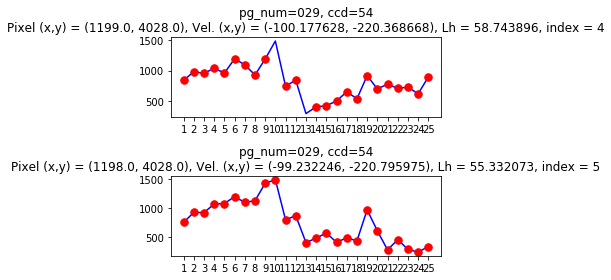

In [32]:
pg_num = 29
ccd_num = 54

results_dir = '/epyc/projects2/smotherh/DECAM_Data_Reduction/kbmod_results/{0:03}/{1:02d}/'.format(pg_num,ccd_num)
im_dir = '/epyc/users/smotherh/pointing_groups/Pointing_Group_{0:03}/warps/{1:02d}/'.format(pg_num,ccd_num)
suffix = 'targeted_Static_Mask_DETECTED_noclusterstampfilt'
suffix = 'sft_all'
suffix = 'sft_none'
def target_pg_results(pg_num, ccd_num, results_dir, im_dir, suffix, stamps=None, center_thresh=None):
    known_format = "pg{:03d}_ccd{:02d}"
    known_data = []
    for key in allObjectData.keys():
        if key != 'legend':
            known_data.append(np.array([int(key[2:5]), int(key[9:])]))
    times_filename = os.path.join(results_dir, 'times_%s.txt' % suffix)
    stamper = create_stamps()

    times_list = stamper.load_times(times_filename)
    object_key = known_format.format(pg_num, ccd_num)
    xy_array = allObjectData[object_key][5]
    v_array = allObjectData[object_key][2]
    v_mag.append(allObjectData[object_key][1])

    lc_filename = os.path.join(results_dir, 'lc_%s.txt' % suffix)
    psi_filename = os.path.join(results_dir, 'psi_{}.txt'.format(suffix))
    phi_filename = os.path.join(results_dir, 'phi_{}.txt'.format(suffix))
    lc_index_filename = os.path.join(results_dir, 'lc_index_%s.txt' % suffix)
    lc_list,lc_index = stamper.load_lightcurves(lc_filename,lc_index_filename)
    psi,phi,lc_index = stamper.load_psi_phi(psi_filename, phi_filename, lc_index_filename)
    stamp_filename = os.path.join(results_dir, 'ps_%s.txt' % suffix)
    result_filename = os.path.join(results_dir, 'results_%s.txt' % suffix)
    results = stamper.load_results(result_filename)
    stamps_fig, object_found, found_idx = stamper.target_results(
        np.array(results), np.array(lc_list), np.array(lc_index), xy_array, target_vel=v_array,
        stamps=stamps, center_thresh=center_thresh, vel_tol=2, atol=2, title_info='pg_num={:03d}, ccd={:02d}'.format(pg_num, ccd_num))

target_pg_results(pg_num, ccd_num, results_dir, im_dir, suffix)

In [4]:
def show_pg_results(pg_num, ccd_num, suffix='current', plot_stamps='coadd', cutoff=0.0, index=None):
        # Directory where output from kbmod search are located
    res_per_ccd = []
    all_coadd_stamps = []
    good_coadd_stamps = []
    all_stamp_probs=[]
    found_stamps=[]
    found_results = {}
    num_except = 0
    num_stamps = 0
    results_dir = '/epyc/projects2/smotherh/DECAM_Data_Reduction/kbmod_results/{0:03}/{1:02d}/'.format(pg_num,ccd_num)
    #im_dir = '/epyc/projects2/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{0:03}/warps/{1:02d}/'.format(pg_num,ccd_num)
    im_dir = '/epyc/users/smotherh/pointing_groups/Pointing_Group_{0:03}/warps/{1:02d}/'.format(pg_num,ccd_num)

    times_filename = os.path.join(results_dir, 'times_%s.txt' % suffix)
    stamper = create_stamps()

    times_list = stamper.load_times(times_filename)
    keep_idx,results,stamper,stamps,all_stamps,lc_list,psi_list,phi_list,lc_index = loadStamps(results_dir,times_list,im_dir,suffix)
        #good_idx = rfc_filter(stamps)
    num_stamps += len(stamps)
    if cutoff==0:
        good_idx = no_filter(stamps)
    else:
        good_idx = cnn_filter(np.copy(stamps),cutoff=cutoff)
    res_per_ccd.append(len(good_idx))
    if len(good_idx)<1:
        print('Failed CCN Filtering. Continuing...')
        return(False)
    if np.count_nonzero(results) != 0:
        if plot_stamps=='coadd':
            if len(lc_list)==1:
                results=[results]
            stamps_fig = stamper.plot_stamps(
                results[good_idx], np.array(lc_list)[good_idx], np.array(lc_index)[good_idx], np.copy(stamps[good_idx]), 0.03)
            #stamps_fig = stamper.plot_stamps(results, lc_list, lc_index, stamps, 0.03)
        elif plot_stamps=='all':
            if len(lc_list)==1:
                results=[results]
            print('Plotting {} results'.format(len(good_idx)))
            if index is None:
                for i in good_idx:
                    stamps_fig = stamper.plot_all_stamps(
                        results[i], np.array(lc_list)[i], np.array(lc_index)[i], np.copy(stamps[i]), np.copy(all_stamps[i]))
            else:
                stamps_fig = stamper.plot_all_stamps(
                        results[index], np.array(lc_list)[index], np.array(lc_index)[index], np.copy(stamps[index]), np.copy(all_stamps[index]))
    return(stamps[good_idx])
#stamps = show_pg_results(79,30,cutoff=0.0, suffix='mask_duallh_gpu', plot_stamps='all')

In [11]:
import pickle
with open('/epyc/users/smotherh/LoriAllen/pointing_metadata/known_objects/aligned_object_data.pkl', 'rb') as f:
        allObjectData = pickle.load(f)
#known_data = np.loadtxt('/epyc/projects2/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/known_object_list.txt')
remove_keys = ['pg026_ccd56', 'pg026_ccd50', 'pg067_ccd05', 'pg102_ccd54', 'pg102_ccd04', 'pg102_ccd62']
for key in remove_keys:
    _ = allObjectData.pop(key,None)
known_format = "pg{:03d}_ccd{:02d}"
known_data = []
for key in allObjectData.keys():
    if key != 'legend':
        known_data.append(np.array([int(key[2:5]), int(key[9:])]))
with open('/astro/store/epyc/users/smotherh/kbmod_epyc/notebooks/rfc_kbmod.model', 'rb') as pickle_file:
    ml_model = pickle.load(pickle_file)
    

In [14]:
res_per_cutoff = []
comp_per_cutoff = []

In [44]:
missed_objects.keys()

dict_keys(['pg026_ccd56', 'pg026_ccd50', 'pg067_ccd05', 'pg067_ccd59', 'pg099_ccd07', 'pg102_ccd54', 'pg102_ccd04', 'pg102_ccd62'])

In [42]:
missed_objects.keys()

dict_keys(['pg026_ccd50', 'pg067_ccd05', 'pg102_ccd54', 'pg102_ccd04', 'pg102_ccd62'])

/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in true_divide
/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in true_divide
/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in true_divide
/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in true_divide
/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in true_divide
/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in true_divide
/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in true_divide
/epyc/opt/anaconda-2019/lib/python3.7/site-packages/ipy

Found 14 objects
Missed 2 objects
Exceptions 1


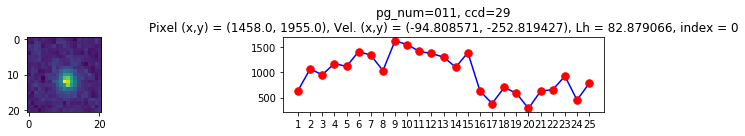

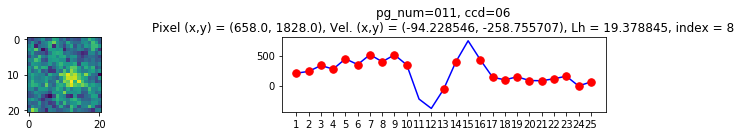

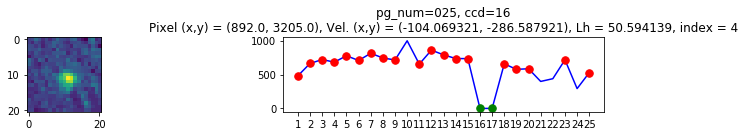

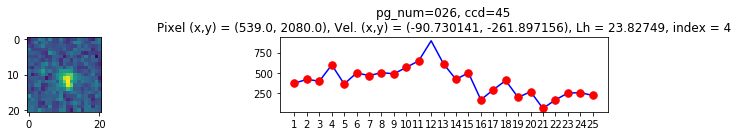

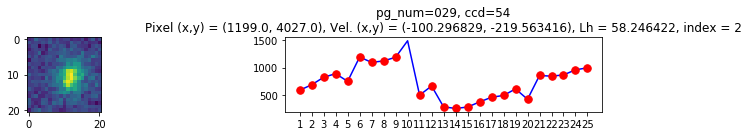

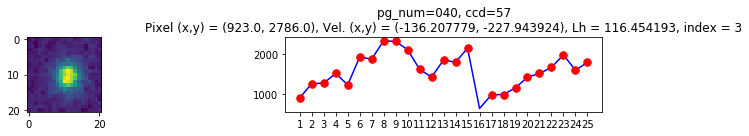

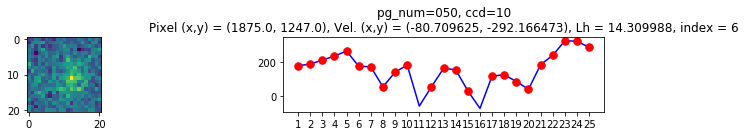

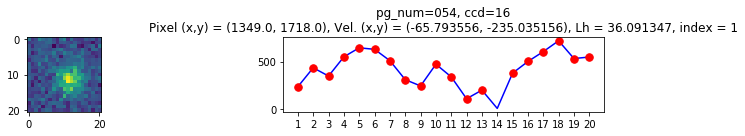

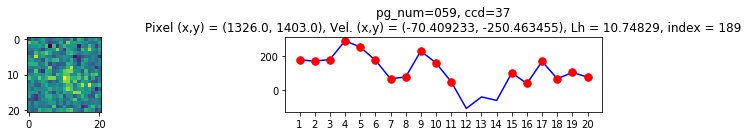

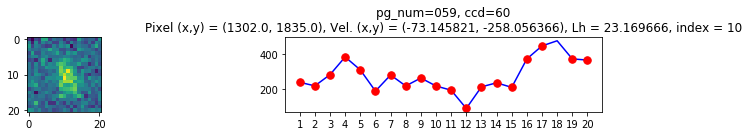

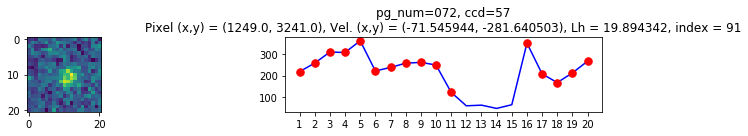

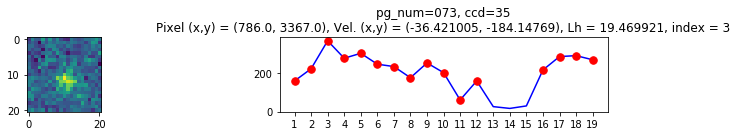

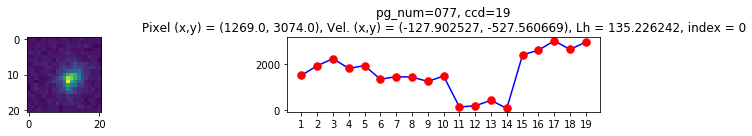

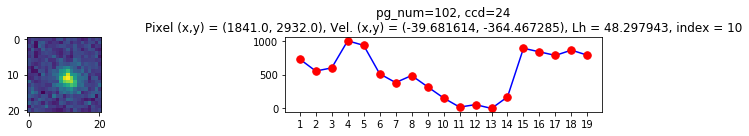

In [35]:
all_good_idx = []
num_found_objects=0
found_objects={}
missed_objects={}
found_vmag = []
v_mag = []
num_results_neighbor = []
res_per_ccd = []
all_coadd_stamps = []
good_coadd_stamps = []
all_stamp_probs=[]
found_stamps=[]
found_results = {}
num_except = 0
num_stamps = 0
exception_list = []
for pgccd in known_data:
    pg_num = int(pgccd[0])
    ccd_num = int(pgccd[1])

    results_dir = '/epyc/projects2/smotherh/DECAM_Data_Reduction/kbmod_results/{0:03}/{1:02d}/'.format(pg_num,ccd_num)
    im_dir = '/epyc/users/smotherh/pointing_groups/Pointing_Group_{0:03}/warps/{1:02d}/'.format(pg_num,ccd_num)
    #suffix = 'more_objs'
    #suffix = 'false_positives_mask'
    #suffix = 'mask_duallh_256'
    #suffix = 'mask_duallh_gpu_reduce_first_night'
    #suffix = 'false_positives'
    #suffix = 'target_nomask'
    #suffix = 'aligned_flux_512'
    suffix = 'Static_Mask_DETECTED'
    #suffix = 'targeted'


    times_filename = os.path.join(results_dir, 'times_%s.txt' % suffix)
    stamper = create_stamps()
    try:
        object_key = known_format.format(pg_num, ccd_num)
        xy_array = allObjectData[object_key][5]
        v_array = allObjectData[object_key][2]
        v_mag.append(allObjectData[object_key][1])
        times_list = stamper.load_times(times_filename)
        keep_idx,results,stamper,stamps,all_stamps,lc_list,psi_list,phi_list,lc_index = loadStamps(results_dir,im_dir,suffix)
        all_coadd_stamps.append(all_stamps)
    except Exception as e:
        exception_list.append(e)
        num_except+=1
        continue
        #good_idx = rfc_filter(stamps)
    num_stamps += len(stamps)

    if len(stamps)>0:
        good_idx = cnn_filter(np.copy(stamps),cutoff=0.0)
        #good_idx = no_filter(stamps)
        #good_idx = cnn_filter_all_stamps(all_stamps)
    else:
        print('No results found...')
        good_idx = []
    res_per_ccd.append(len(good_idx))
    if len(good_idx)<1:
        missed_objects[object_key] = allObjectData[object_key]
        print('Failed CCN Filtering. Continuing...')
        continue
    for idx in good_idx:
        good_coadd_stamps.append(stamps[idx])
    #num_results_neighbor.append(len(cnn_good_idx))
    if np.count_nonzero(results) != 0:
        if len(lc_list)==1:
            results=np.array([results])
        #stamps_fig, object_found, found_idx = stamper.target_stamps(
        #    results, lc_list, lc_index, stamps, 0.03, xy_array, target_vel=v_array,
        #    vel_tol=30, atol=5, title_info='pg_num={:03d}, ccd={:02d}'.format(*pgccd.astype(int)))
        #all_coadd_stamps.append([element for i, element in enumerate(stamps) if i not in found_idx])
        stamps_fig, object_found, found_idx = stamper.target_results(
            np.array(results)[good_idx], np.array(lc_list)[good_idx], np.array(lc_index)[good_idx], xy_array,
            stamps=np.copy(stamps[good_idx]), center_thresh=0.00, target_vel=v_array,
            vel_tol=5, atol=3, title_info='pg_num={:03d}, ccd={:02d}'.format(*pgccd.astype(int)))
        if object_found:
            num_found_objects+=1
            found_stamps.append(stamps[good_idx][found_idx])
            found_vmag.append(allObjectData[object_key][1])
            found_objects[object_key] = allObjectData[object_key]
            found_results[object_key] = results[good_idx][found_idx]
        else:
            missed_objects[object_key] = allObjectData[object_key]
    else:
        missed_objects[object_key] = allObjectData[object_key]
print('Found {} objects'.format(len(found_objects)))
print('Missed {} objects'.format(len(missed_objects)))
print('Exceptions {}'.format(num_except))
        #stamps_fig = stamper.plot_stamps(results, lc_list, lc_index, stamps, 0.03)
res_per_cutoff.append(res_per_ccd)
comp_per_cutoff.append(len(found_vmag)/len(v_mag))

In [110]:
def norm_stamps(stamp_list):
    normed_stamps = []
    sigmaG_coeff =  0.7413
    for stamp in stamp_list:
        stamp = np.copy(stamp)
        stamp[np.isnan(stamp)] = 0
        per25,per50,per75 = np.percentile(stamp,[25,50,75])
        sigmaG = sigmaG_coeff * (per75 - per25)
        stamp[stamp<(per50-2*sigmaG)] = per50-2*sigmaG
        stamp -= np.min(stamp)
        stamp /= np.sum(stamp)
        normed_stamps.append(stamp.reshape(21,21))
    normed_stamps = np.array(normed_stamps)
    return(normed_stamps)

foo = np.array(found_stamps).reshape(14,21,21)
foo[np.isnan(foo)] = 0
foo = norm_stamps(foo)
np.save('normed_individual_real.npy',foo)


The mask fraction is: 0.009095278549397087


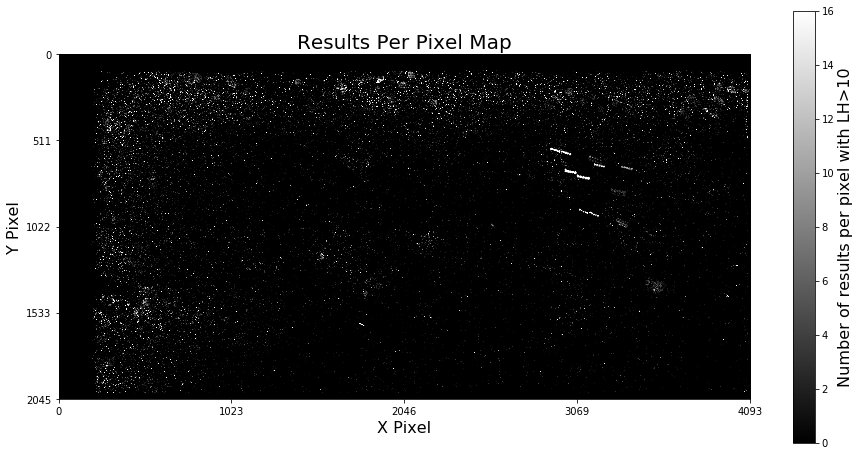

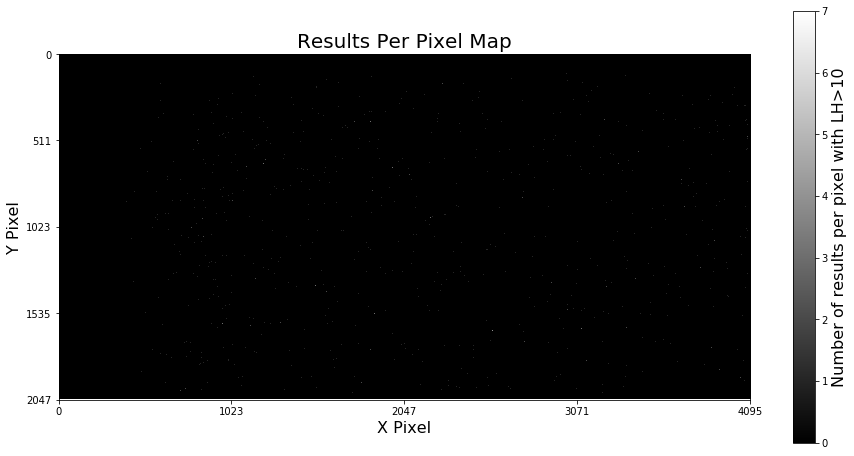

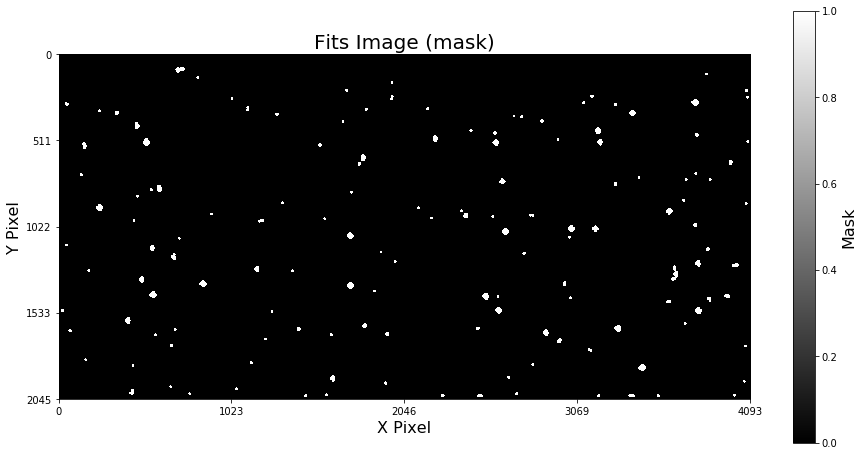

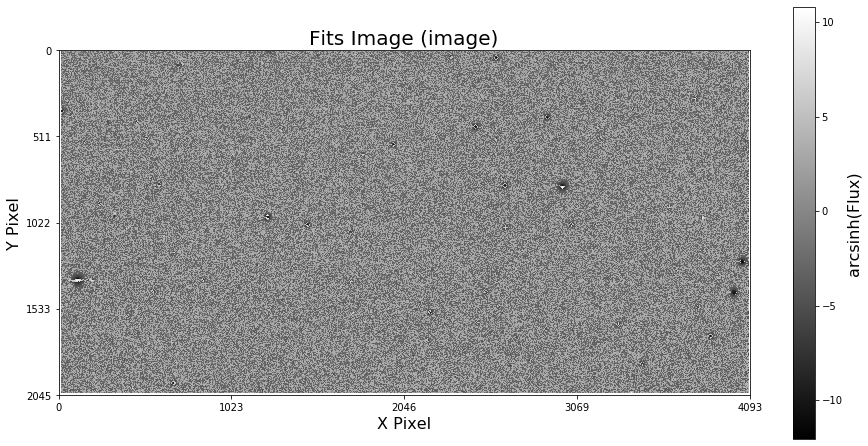

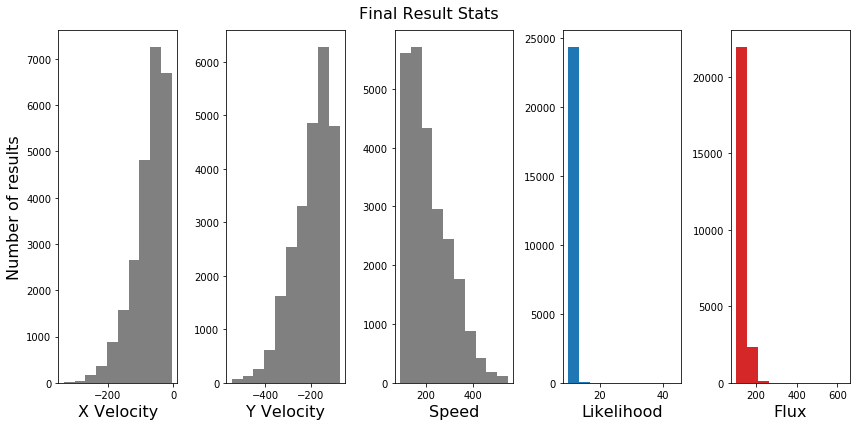

In [39]:
import pickle
from astropy.io import fits
import os

def load_results(pg_num, ccd_num, suffix):
    results_dir = '/epyc/projects2/smotherh/DECAM_Data_Reduction/kbmod_results/{0:03}/{1:02d}/'.format(pg_num,ccd_num)
    times_filename = os.path.join(results_dir, 'times_%s.txt' % suffix)
    image_list = sorted(os.listdir(im_dir))
    image_list = [os.path.join(im_dir, im_name) for im_name in image_list]

    stamper = create_stamps()
    lc_filename = os.path.join(results_dir, 'lc_%s.txt' % suffix)
    psi_filename = os.path.join(results_dir, 'psi_{}.txt'.format(suffix))
    phi_filename = os.path.join(results_dir, 'phi_{}.txt'.format(suffix))
    lc_index_filename = os.path.join(results_dir, 'lc_index_%s.txt' % suffix)
    lc_list,lc_index = stamper.load_lightcurves(lc_filename,lc_index_filename)
    psi,phi,lc_index = stamper.load_psi_phi(psi_filename, phi_filename, lc_index_filename)
    result_filename = os.path.join(results_dir, 'results_%s.txt' % suffix)

    result_exists = os.stat(result_filename).st_size

    if result_exists:
        results = stamper.load_results(result_filename)
    return(results)

def load_px_stats(pg_num, ccd_num, suffix):
    results_dir = '/epyc/projects2/smotherh/DECAM_Data_Reduction/kbmod_results/{0:03}/{1:02d}/'.format(pg_num,ccd_num)
    with open(results_dir+'res_per_px_stats_{}.pkl'.format(suffix), 'rb') as f:
        stats = pickle.load(f)
    return(stats)

def plot_px_stats(pg_num, ccd_num, suffix, save_plot=True,lims=[[0,-1],[0,-1]], res_stage='gpu'):
    
    if res_stage=='gpu':
        px_stats = load_px_stats(pg_num, ccd_num, suffix)
        plot_helper(px_stats['num_res_per_px'], lims, 'Number of results per pixel with LH>10', default_scale)
    elif res_stage=='final':
        results = pd.DataFrame(load_results(pg_num, ccd_num, suffix))
        num_res_per_px = np.zeros([2048,4096])
        for i, line in results.iterrows():
            num_res_per_px[int(line['x']),int(line['y'])]+=1
        plot_helper(num_res_per_px, lims, 'Number of results per pixel with LH>10', default_scale)
    plt.xlabel('X Pixel', fontsize=16)
    plt.ylabel('Y Pixel', fontsize=16)
    plt.title('Results Per Pixel Map',fontsize=20)
    if save_plot:
        plt.savefig('res_per_pixel_{}_{}_{}.png'.format(pg_num, ccd_num, suffix))
        
def count_array_set_bit(mask):
    mask = np.array(mask).astype(int)
    binary_mask = np.zeros(np.shape(mask)).astype(int)
    while (mask>0).any():
        binary_mask += np.bitwise_and(mask,1)
        mask = np.right_shift(mask,1)
    return(binary_mask)

def default_scale(image):
    return(image)

def plot_helper(image, lims, cbar_label, scale):
    fig = plt.figure(figsize=[12,6])
    ax = fig.add_axes([0,0,1,1])
    limited_image = image[lims[1][0]:lims[1][1],lims[0][0]:lims[0][1]]
    im = ax.imshow(scale(limited_image), cmap='gray')
    c_bar = fig.colorbar(im, ax=ax)
    c_bar.set_label(cbar_label, fontsize=16)
    
    y_px_max, x_px_max = np.shape(limited_image)
    x_tick_range = np.linspace(0, x_px_max, 5).astype(int)
    x_tick_label = x_tick_range + lims[0][0]
    ax.set_xticks(x_tick_range)
    ax.set_xticklabels(x_tick_label)
    
    y_tick_range = np.linspace(0, y_px_max, 5).astype(int)
    y_tick_label = y_tick_range + lims[1][0]
    ax.set_yticks(y_tick_range)
    ax.set_yticklabels(y_tick_label)
    

def plot_fits(pg_num, ccd_num, save_plot=False, fits_plane='image', mask_type=None, visit_num=0, lims=[[0,-1],[0,-1]]):
    image_dir = '/epyc/users/smotherh/pointing_groups/Pointing_Group_{0:03}/warps/{1:02}/'.format(pg_num,ccd_num)
    visits = os.listdir(image_dir)
    hdul = fits.open(image_dir+visits[visit_num])
    mask_bits_dict = {'BAD': 0, 'CLIPPED': 9, 'CR': 3, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4,
             'INEXACT_PSF': 10, 'INTRP': 2, 'NOT_DEBLENDED': 11, 'NO_DATA': 8, 'REJECTED': 12,
             'SAT': 1, 'SENSOR_EDGE': 13, 'SUSPECT': 7}
    if fits_plane=='image':
        image_data = hdul[1].data.transpose()
        #image_data = image_data[lims[0][0]:lims[0][1],lims[1][0]:lims[1][1]]
        plot_helper(image_data, lims, 'arcsinh(Flux)', np.arcsinh)
        
    elif fits_plane=='variance':
        image_data = hdul[3].data.transpose()
        #image_data = image_data[lims[0][0]:lims[0][1],lims[1][0]:lims[1][1]]
        plot_helper(image_data, lims, 'Variance', np.arcsinh)

    elif fits_plane=='mask':
        mask_data = hdul[2].data.transpose()
        if mask_type is not None:
            mask_bits=0
            for bit in mask_type:
                mask_bits += 2**mask_bits_dict[bit]
            image_data = count_array_set_bit(mask_data & mask_bits)
            plot_helper(image_data, lims, 'Mask', default_scale)
            mask_fraction = np.size(image_data[image_data!=0])/np.size(image_data)
            print('The mask fraction is: {}'.format(mask_fraction))
        else:
            image_data = count_array_set_bit(mask_data)
            plot_helper(image_data, lims, 'Mask', default_scale)
        
    plt.xlabel('X Pixel', fontsize=16)
    plt.ylabel('Y Pixel', fontsize=16)
    plt.title('Fits Image ({})'.format(fits_plane),fontsize=20)
    return(image_data)

def plot_res_stats(pg_num, ccd_num, suffix, lims=[[0,-1],[0,-1]]):
    fig, ax = plt.subplots(1,5, figsize=(12,6))
    lims = np.array(lims)
    lims[lims==-1] = 1e16
    
    results = pd.DataFrame(load_results(pg_num, ccd_num, suffix))

    x_mask = np.logical_and(results['x']>lims[1,0],results['x']<lims[1,1])
    y_mask = np.logical_and(results['y']>lims[0,0],results['y']<lims[0,1])
    masked_results = results[np.logical_and(x_mask,y_mask)]
    vx = masked_results['vx'].to_numpy()
    vy = masked_results['vy'].to_numpy()
    ax[0].hist(vx,color='gray')
    ax[0].set_ylabel('Number of results', fontsize=16)
    ax[0].set_xlabel('X Velocity', fontsize=16)
    ax[1].hist(vy,color='gray')
    ax[1].set_xlabel('Y Velocity', fontsize=16)
    ax[2].hist(np.linalg.norm([vx,vy],axis=0),color='gray')
    ax[2].set_xlabel('Speed', fontsize=16)
    ax[3].hist(masked_results['lh'].to_numpy(), color='tab:blue')
    ax[3].set_xlabel('Likelihood',fontsize=16)
    ax[4].hist(masked_results['flux'].to_numpy(), color='tab:red')
    ax[4].set_xlabel('Flux',fontsize=16)
    fig.suptitle('Final Result Stats', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

def plot_fits_px_stats(pg_num, ccd_num, suffix,
    fits_plane='image', mask_type=None, lims=[[0,-1],[0,-1]], res_stage='gpu'):
    
    plot_px_stats(pg_num, ccd_num, suffix, lims=lims, res_stage='gpu')
    plot_px_stats(pg_num, ccd_num, suffix, lims=lims, res_stage='final')
    for i in range(1):
        image_data = plot_fits(pg_num, ccd_num, fits_plane=fits_plane, mask_type=mask_type, visit_num=i, lims=lims)
        image_data = plot_fits(pg_num, ccd_num, fits_plane='image', mask_type=mask_type, visit_num=i, lims=lims)


    plot_res_stats(pg_num, ccd_num, suffix, lims=lims)
    return(image_data)

interesting_area1 = [[1670,1750],[1060,1125]]
interesting_area2 = [[1100,1200],[1520,1650]]
interesting_area2_unzoom = [[900,1400],[1320,1850]]
interesting_area3 = [[2400,3100],[400,850]]

image_data = plot_fits_px_stats(11,6,'Static_Mask_DETECTED', fits_plane='mask', mask_type=['DETECTED'])

In [70]:
allObjectData.keys()

dict_keys(['legend', 'pg011_ccd29', 'pg011_ccd06', 'pg025_ccd16', 'pg026_ccd56', 'pg026_ccd45', 'pg026_ccd50', 'pg029_ccd54', 'pg040_ccd57', 'pg050_ccd10', 'pg054_ccd16', 'pg059_ccd37', 'pg059_ccd60', 'pg067_ccd05', 'pg067_ccd59', 'pg072_ccd57', 'pg073_ccd35', 'pg077_ccd19', 'pg099_ccd07', 'pg102_ccd54', 'pg102_ccd54_1', 'pg102_ccd04', 'pg102_ccd24', 'pg102_ccd62'])

Plotting 345 results


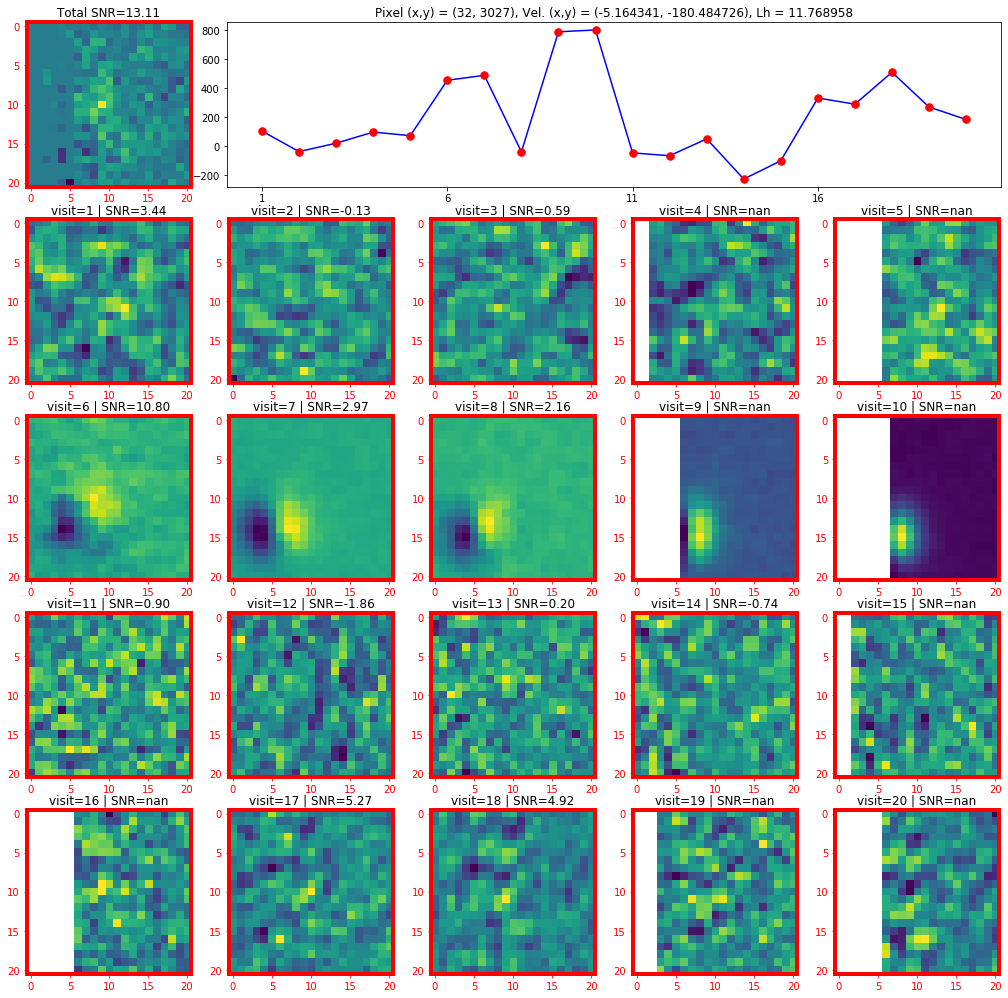

In [57]:
stamps = show_pg_results(59,37,cutoff=0.0, suffix='Static_Mask_DETECTED', plot_stamps='all', index=100)
#plt.savefig('2001_FQ185_Recovery.png')

In [41]:
nocnnstamps = np.copy(found_stamps)

In [39]:
cnn5stamps = np.copy(found_stamps)

In [55]:
np.array([(nocnnstamps[3]==stamp).all() for stamp in np.concatenate(cnn5stamps)]).any()

True

In [58]:
failing_stamps = []
for stamp in np.concatenate(nocnnstamps):
    if ~np.array([(stamp==x).all() for x in np.concatenate(cnn5stamps)]).any():
        failing_stamps.append(stamp.reshape(21,21))

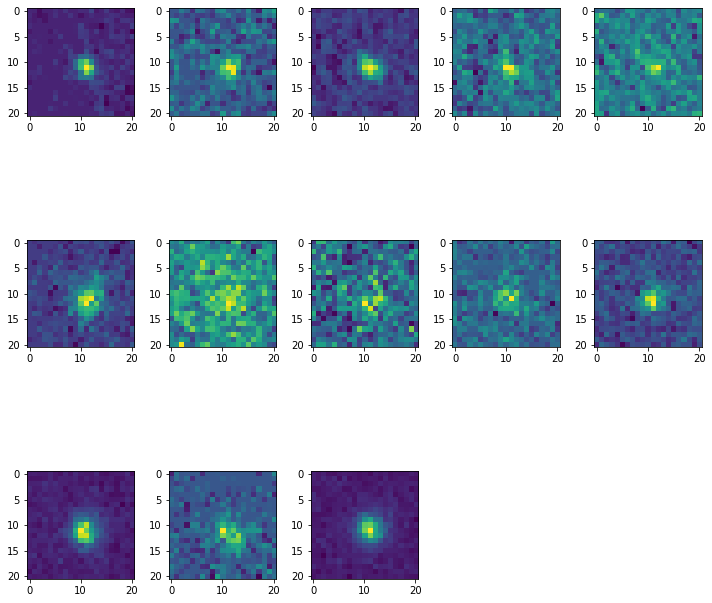

In [73]:
plot_stamps(np.concatenate(cnn5stamps))

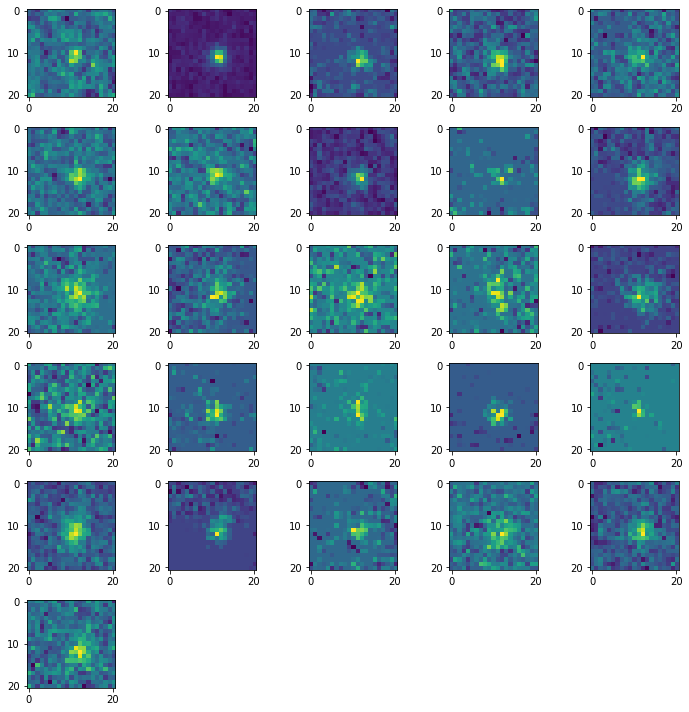

In [72]:
def plot_stamps(failing_stamps):
    fig_0,ax_0 = plt.subplots(nrows=int(len(failing_stamps)/5)+1,ncols=5,figsize=[10,10])
    ax_0 = ax_0.reshape(-1)
    for i,ax in enumerate(ax_0):
        if i<len(failing_stamps):
            ax.imshow(failing_stamps[i].reshape(21,21))
        else:
            ax.set_visible(False)
    plt.tight_layout()
plot_stamps(failing_stamps)

In [16]:
def plot_true_false(true, false):
    fig_0,ax_0 = plt.subplots(nrows=2,ncols=5,figsize=[8,4])
    fig_1,ax_1 = plt.subplots(nrows=2,ncols=5,figsize=[8,4])
    ax_0 = ax_0.reshape(-1)
    ax_1 = ax_1.reshape(-1)
    true_int_list = np.random.choice(len(true),10,replace=False)
    false_int_list = np.random.choice(len(false),10,replace=False)
    for i, ax in enumerate(ax_0):
        ax.imshow(true[true_int_list[i]].reshape(21,21))
    for i, ax in enumerate(ax_1):
        ax.imshow(false[false_int_list[i]].reshape(21,21))
    fig_0.suptitle('True',fontsize=16)
    fig_1.suptitle('False',fontsize=16)
    fig_0.tight_layout()
    fig_1.tight_layout()

In [21]:
bar = []
for stamp in all_coadd_stamps:
    if len(stamp)>0:
        if (np.shape(stamp)[1]==25):
            bar.append(stamp)
false_positives = np.concatenate(bar,axis=0)
#np.save('masked_false_positives.npy',np.concatenate(bar,axis=0))

Text(0, 0.5, 'Normalized Number of Candidates per CCD')

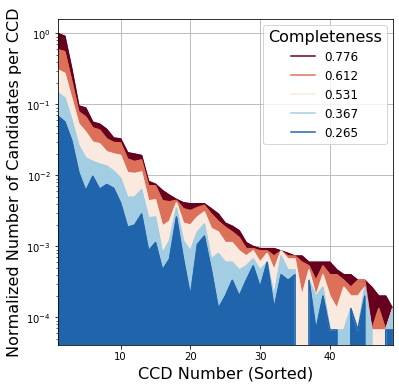

In [12]:
import numpy as np
import matplotlib.pyplot as plt
#np.save('Results_Per_Cutoff_Stats.npy',[comp_per_cutoff,res_per_cutoff])
#comp_per_cutoff,res_per_cutoff = np.load('Results_Per_Cutoff_Stats.npy',allow_pickle=True)
comp_per_cutoff = np.array(comp_per_cutoff)
res_per_cutoff = np.array(res_per_cutoff)
idx = np.argsort(comp_per_cutoff)
jdx = np.argsort(res_per_cutoff[idx[-1]])[::-1]
col = plt.cm.RdBu(np.linspace(0,.9,len(comp_per_cutoff)))
legend = []
x = np.linspace(1,len(res_per_cutoff[0]),len(res_per_cutoff[0]))
#for i,res in enumerate(res_per_cutoff):
#    plt.hist(res,range=(0,len(res_per_cutoff[0])),color='k',alpha=.1+i/len(res_per_cutoff))
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=[6,6])
for i,res in enumerate(np.array(res_per_cutoff)[idx][::-1]):
    ax.fill_between(x,np.array(res)[jdx]/res_per_cutoff[idx][-1][0],0,color=col[i])
    ax.semilogy(x,np.array(res)[jdx]/res_per_cutoff[idx][-1][0],color=col[i])
    #ax[0].plot(x,np.array(res)[jdx],color=col[i])

    legend.append("{:.3f}".format(np.array(comp_per_cutoff)[idx][::-1][i]))
ax.set_axisbelow(True)
ax.grid()
ax.legend(legend,title="Completeness",fontsize=12,title_fontsize=16)
ax.set_xlim([1,49])
ax.set_xlabel('CCD Number (Sorted)',fontsize=16)
ax.set_ylabel('Normalized Number of Candidates per CCD',fontsize=16)
#plt.savefig('ProposalCNNExample.png')

[16889, 15030, 953, 183, 2357, 156, 182, 382, 540, 270, 422, 207, 3599, 7401, 32, 182, 306, 47, 22, 33, 6, 12, 5, 54, 12, 24, 12, 131, 67, 50, 10, 81, 121, 57, 69, 101, 656, 308, 366, 124, 17, 61, 131, 149, 214, 74, 110, 194, 92]


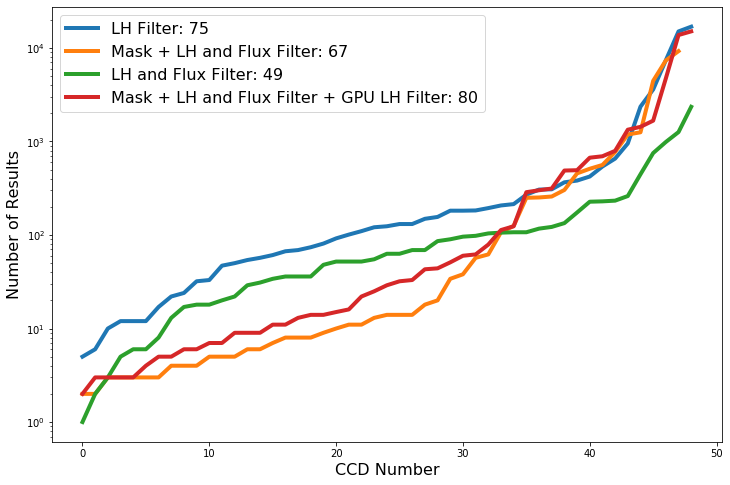

In [8]:
comp_per_cutoff,res_per_cutoff = np.load('Results_Per_Cutoff_Stats.npy',allow_pickle=True)
dual_lh_filter = np.loadtxt('/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/dual_lh_filter_results.txt')
dual_lh_filter_nomask = np.loadtxt('/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/dual_lh_filter_nomask_results.txt')
mask_duallh_gpu = np.loadtxt('/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/mask_duallh_gpu_results.txt')
plt.figure(figsize=[12,8])
sorted_idx = np.argsort(res_per_cutoff[4])
plt.semilogy(np.sort(res_per_cutoff[4]), lw=4)
plt.semilogy(np.sort(dual_lh_filter), lw=4)
plt.semilogy(np.sort(dual_lh_filter_nomask), lw=4)
plt.semilogy(np.sort(mask_duallh_gpu), lw=4)
plt.legend(['LH Filter: 75','Mask + LH and Flux Filter: 67','LH and Flux Filter: 49', 'Mask + LH and Flux Filter + GPU LH Filter: 80'],fontsize=16)
plt.ylabel('Number of Results',fontsize=16)
plt.xlabel('CCD Number', fontsize=16)


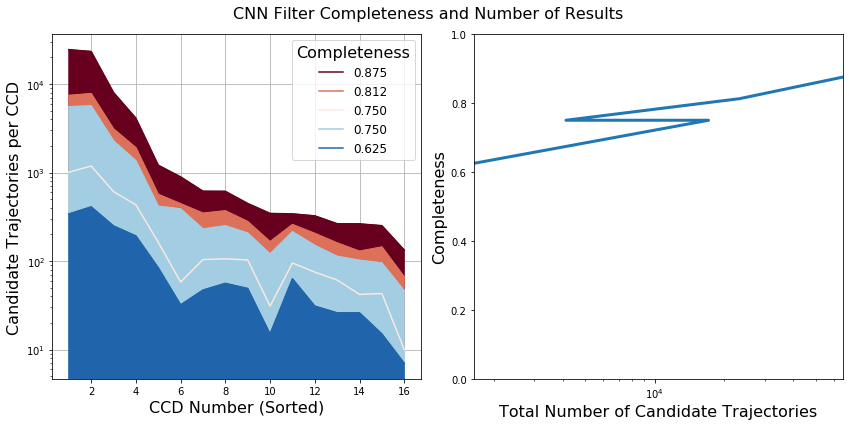

In [32]:
#np.save('Results_Per_Cutoff_Stats.npy',[comp_per_cutoff,res_per_cutoff])
#comp_per_cutoff,res_per_cutoff = np.load('Results_Per_Cutoff_Stats.npy',allow_pickle=True)
idx = np.argsort(comp_per_cutoff)
jdx = np.argsort(res_per_cutoff[idx[-1]])[::-1]
col = plt.cm.RdBu(np.linspace(0,.9,len(comp_per_cutoff)))
legend = []
x = np.linspace(1,len(res_per_cutoff[0]),len(res_per_cutoff[0]))
#for i,res in enumerate(res_per_cutoff):
#    plt.hist(res,range=(0,len(res_per_cutoff[0])),color='k',alpha=.1+i/len(res_per_cutoff))
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=[12,6])
for i,res in enumerate(np.array(res_per_cutoff)[idx][::-1]):
    ax[0].fill_between(x,np.array(res)[jdx],0,color=col[i])
    ax[0].semilogy(x,np.array(res)[jdx],color=col[i])
    #ax[0].plot(x,np.array(res)[jdx],color=col[i])

    legend.append("{:.3f}".format(np.array(comp_per_cutoff)[idx][::-1][i]))
ax[0].set_axisbelow(True)
ax[0].grid()
ax[0].legend(legend,title="Completeness",fontsize=12,title_fontsize=16)
#ax[0].set_xlim([1,49])
ax[0].set_xlabel('CCD Number (Sorted)',fontsize=16)
ax[0].set_ylabel('Candidate Trajectories per CCD',fontsize=16)
sum_array = []
for res in res_per_cutoff:
    sum_array.append(np.sum(res))
ax[1].semilogx(np.array(sum_array)[idx],np.array(comp_per_cutoff)[idx],lw=3)
ax[1].set_ylim([0,1])
ax[1].set_xlim([np.min(sum_array),np.max(sum_array)])
ax[1].set_xlabel('Total Number of Candidate Trajectories',fontsize=16)
ax[1].set_ylabel('Completeness',fontsize=16)
_ = fig.suptitle('CNN Filter Completeness and Number of Results',fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.savefig('Resnet_Masks_Stats.png')
#plt.figure()
#_=plt.semilogx(res_per_cutoff, comp_per_cutoff)

In [47]:
print(len(good_coadd_stamps))
print(num_stamps)
print(len(good_coadd_stamps)/num_stamps)

51223
52501
0.9756576065217806


0.11058329973101697
0.3728957862828516


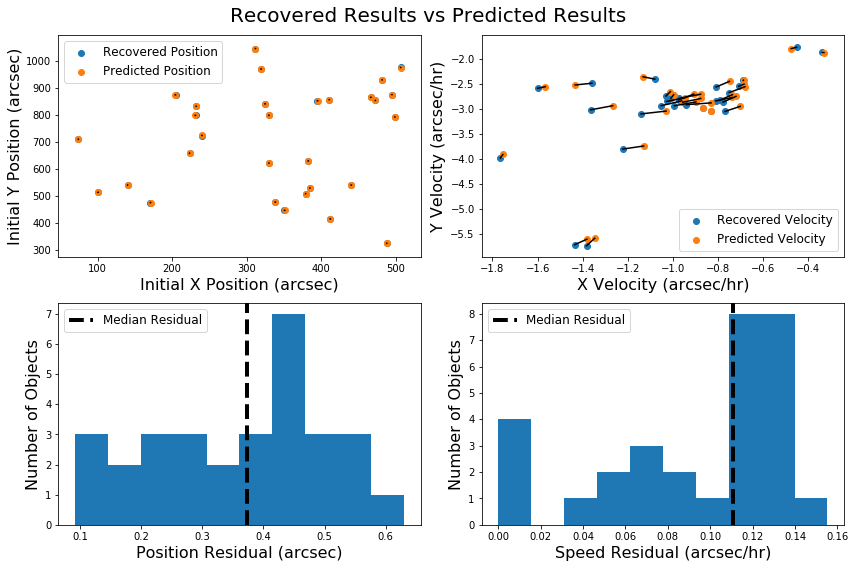

In [27]:
found_pos = []
found_vel = []
found_speed = []
pred_pos = []
pred_vel = []
pred_speed = []

for key in found_objects:
    found_x = found_results[key][0][2]
    found_y = found_results[key][0][3]
    found_vx = found_results[key][0][4]
    found_vy = found_results[key][0][5]
    found_pos.append([found_x,found_y])
    found_vel.append([found_vx,found_vy])
    found_speed.append(np.linalg.norm([found_vx,found_vy]))
    pred_pos.append(found_objects[key][5])
    pred_vel.append(found_objects[key][2])
    pred_speed.append(np.linalg.norm(found_objects[key][2]))
found_pos = np.array(found_pos)*0.26
found_vel = np.array(found_vel)*0.26/24
found_speed = np.array(found_speed)*0.26/24
pred_pos= np.array(pred_pos)*0.26
pred_vel = np.array(pred_vel)*0.26/24
pred_speed = np.array(pred_speed)*0.26/24

fig, ax = plt.subplots(ncols=2, nrows=2,figsize=[12,8])

ax[0,0].scatter(found_pos[:,0],found_pos[:,1],c='tab:blue')
ax[0,0].scatter(pred_pos[:,0],pred_pos[:,1],c='tab:orange')
ax[0,0].set_xlabel('Initial X Position (arcsec)',fontsize=16)
ax[0,0].set_ylabel('Initial Y Position (arcsec)',fontsize=16)
ax[0,0].legend(['Recovered Position','Predicted Position'],fontsize=12)
for i in range(len(found_pos)):
    ax[0,0].plot([found_pos[i,0],pred_pos[i,0]],[found_pos[i,1],pred_pos[i,1]],c='k')

ax[0,1].scatter(found_vel[:,0],found_vel[:,1],c='tab:blue')
ax[0,1].scatter(pred_vel[:,0],pred_vel[:,1],c='tab:orange')
ax[0,1].set_xlabel('X Velocity (arcsec/hr)',fontsize=16)
ax[0,1].set_ylabel('Y Velocity (arcsec/hr)',fontsize=16)
ax[0,1].legend(['Recovered Velocity','Predicted Velocity'],fontsize=12)

for i in range(len(found_vel)):
    ax[0,1].plot([found_vel[i,0],pred_vel[i,0]],[found_vel[i,1],pred_vel[i,1]],c='k')
deltaSpeed = np.linalg.norm(found_vel-pred_vel,axis=1)
print(np.median(deltaSpeed))
ax[1,1].hist(deltaSpeed)
ax[1,1].axvline(np.median(deltaSpeed),color='black',lw=4,ls='--')
ax[1,1].set_xlabel('Speed Residual (arcsec/hr)',fontsize=16)
ax[1,1].set_ylabel('Number of Objects',fontsize=16)
ax[1,1].legend(['Median Residual'],fontsize=12)

#_=plt.hist(pred_speed)
deltaPos = np.linalg.norm(found_pos-pred_pos,axis=1)
ax[1,0].hist(deltaPos) #"
print(np.median(deltaPos))
ax[1,0].axvline(np.median(deltaPos),color='black',lw=4,ls='--')
ax[1,0].set_xlabel('Position Residual (arcsec)',fontsize=16)
ax[1,0].set_ylabel('Number of Objects',fontsize=16)
ax[1,0].legend(['Median Residual'],fontsize=12)
fig.suptitle('Recovered Results vs Predicted Results', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])

0.004576315227809531
0.3985446115386676


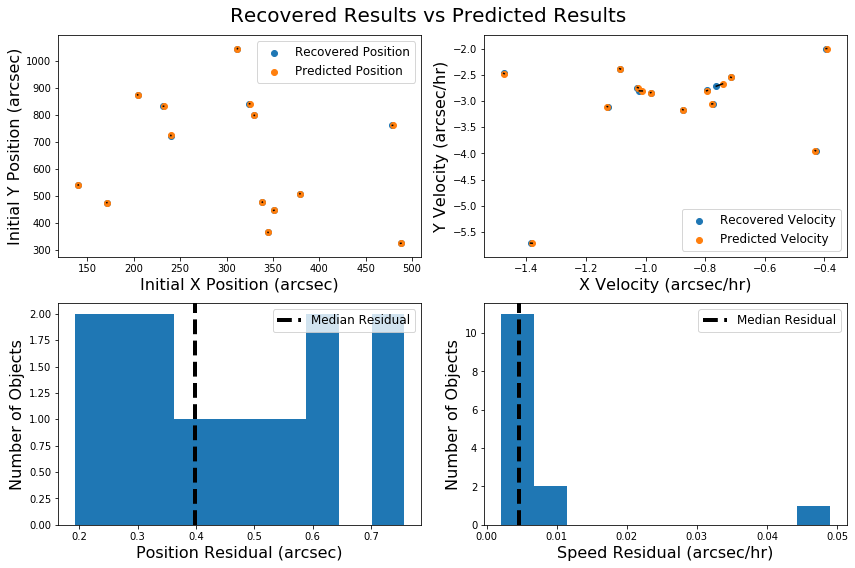

In [36]:
found_pos = []
found_vel = []
found_speed = []
pred_pos = []
pred_vel = []
pred_speed = []

for key in found_objects:
    found_x = found_results[key][0][2]
    found_y = found_results[key][0][3]
    found_vx = found_results[key][0][4]
    found_vy = found_results[key][0][5]
    found_pos.append([found_x,found_y])
    found_vel.append([found_vx,found_vy])
    found_speed.append(np.linalg.norm([found_vx,found_vy]))
    pred_pos.append(found_objects[key][5])
    pred_vel.append(found_objects[key][2])
    pred_speed.append(np.linalg.norm(found_objects[key][2]))
found_pos = np.array(found_pos)*0.26
found_vel = np.array(found_vel)*0.26/24
found_speed = np.array(found_speed)*0.26/24
pred_pos= np.array(pred_pos)*0.26
pred_vel = np.array(pred_vel)*0.26/24
pred_speed = np.array(pred_speed)*0.26/24

fig, ax = plt.subplots(ncols=2, nrows=2,figsize=[12,8])

ax[0,0].scatter(found_pos[:,0],found_pos[:,1],c='tab:blue')
ax[0,0].scatter(pred_pos[:,0],pred_pos[:,1],c='tab:orange')
ax[0,0].set_xlabel('Initial X Position (arcsec)',fontsize=16)
ax[0,0].set_ylabel('Initial Y Position (arcsec)',fontsize=16)
ax[0,0].legend(['Recovered Position','Predicted Position'],fontsize=12)
for i in range(len(found_pos)):
    ax[0,0].plot([found_pos[i,0],pred_pos[i,0]],[found_pos[i,1],pred_pos[i,1]],c='k')

ax[0,1].scatter(found_vel[:,0],found_vel[:,1],c='tab:blue')
ax[0,1].scatter(pred_vel[:,0],pred_vel[:,1],c='tab:orange')
ax[0,1].set_xlabel('X Velocity (arcsec/hr)',fontsize=16)
ax[0,1].set_ylabel('Y Velocity (arcsec/hr)',fontsize=16)
ax[0,1].legend(['Recovered Velocity','Predicted Velocity'],fontsize=12)

for i in range(len(found_vel)):
    ax[0,1].plot([found_vel[i,0],pred_vel[i,0]],[found_vel[i,1],pred_vel[i,1]],c='k')
deltaSpeed = np.linalg.norm(found_vel-pred_vel,axis=1)
print(np.median(deltaSpeed))
ax[1,1].hist(deltaSpeed)
ax[1,1].axvline(np.median(deltaSpeed),color='black',lw=4,ls='--')
ax[1,1].set_xlabel('Speed Residual (arcsec/hr)',fontsize=16)
ax[1,1].set_ylabel('Number of Objects',fontsize=16)
ax[1,1].legend(['Median Residual'],fontsize=12)

#_=plt.hist(pred_speed)
deltaPos = np.linalg.norm(found_pos-pred_pos,axis=1)
ax[1,0].hist(deltaPos) #"
print(np.median(deltaPos))
ax[1,0].axvline(np.median(deltaPos),color='black',lw=4,ls='--')
ax[1,0].set_xlabel('Position Residual (arcsec)',fontsize=16)
ax[1,0].set_ylabel('Number of Objects',fontsize=16)
ax[1,0].legend(['Median Residual'],fontsize=12)
fig.suptitle('Recovered Results vs Predicted Results', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.savefig('ResultsAnalysis.png')

In [74]:
from astropy.io import fits

with open('/epyc/users/smotherh/LoriAllen/pointing_metadata/known_objects/allObjectData_2.pkl', 'rb') as f:
    allObjectData = pickle.load(f)
with open('/epyc/users/smotherh/LoriAllen/pointing_metadata/PickledPointingswSeeing.pkl', 'rb') as f:
    Pointing_Groups = pickle.load(f)
known_data = np.loadtxt('/epyc/projects2/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/known_object_list.txt')
known_format = "pg{:03d}_ccd{:02d}"
known_object_pg = np.unique(np.array(known_data)[:,0]).astype(int)

visit_num = len(visit_list)

all_data = []
median_coadd = []
all_fraction_masked = []

for i,pgccd in enumerate(known_data):
    pg_num = int(pgccd[0])
    ccd = int(pgccd[1])
    visit_id = Pointing_Groups[pg_num]['visit_id'][0]
    imagePath = '/epyc/projects2/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{:03d}'
    diffPath = os.path.join(imagePath.format(pg_num),'warps/{:02d}/{}.fits'.format(int(ccd),visit_id))
    hdul = fits.open(diffPath)
    data = hdul[1].data
    mask = hdul[2].data
    # Bits 0, 1, and 3 correspond to bad pixels, saturated pixels, and cosmic rays in DECam data
    bad_pixel = np.bitwise_and(np.array(mask).astype(int),(1<<0|1<<1|1<<3))
    fraction_masked = len(np.concatenate(np.where(bad_pixel)))/np.size(mask)
    all_fraction_masked.append(fraction_masked)
    print('Pointing Group {} ccd {} is {:.2f} masked'.format(pg_num,ccd,fraction_masked))

Pointing Group 11 ccd 6 is 0.07 masked
Pointing Group 11 ccd 29 is 0.09 masked
Pointing Group 19 ccd 57 is 0.09 masked
Pointing Group 20 ccd 29 is 0.08 masked
Pointing Group 20 ccd 38 is 0.12 masked
Pointing Group 20 ccd 62 is 0.08 masked
Pointing Group 22 ccd 9 is 0.06 masked
Pointing Group 23 ccd 24 is 0.06 masked
Pointing Group 23 ccd 32 is 0.07 masked
Pointing Group 23 ccd 35 is 0.10 masked
Pointing Group 23 ccd 43 is 0.07 masked
Pointing Group 23 ccd 48 is 0.06 masked
Pointing Group 25 ccd 16 is 0.07 masked
Pointing Group 26 ccd 45 is 0.08 masked
Pointing Group 29 ccd 54 is 0.07 masked
Pointing Group 34 ccd 16 is 0.09 masked
Pointing Group 40 ccd 57 is 0.30 masked
Pointing Group 50 ccd 10 is 0.07 masked
Pointing Group 54 ccd 16 is 0.08 masked
Pointing Group 55 ccd 8 is 0.06 masked
Pointing Group 57 ccd 22 is 0.08 masked
Pointing Group 57 ccd 24 is 0.07 masked
Pointing Group 57 ccd 35 is 0.06 masked
Pointing Group 59 ccd 37 is 0.06 masked
Pointing Group 59 ccd 60 is 0.06 masked
Poi

(array([24., 17.,  4.,  1.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([0.05121817, 0.07642111, 0.10162405, 0.12682699, 0.15202994,
        0.17723288, 0.20243582, 0.22763876, 0.2528417 , 0.27804464,
        0.30324758]),
 <a list of 10 Patch objects>)

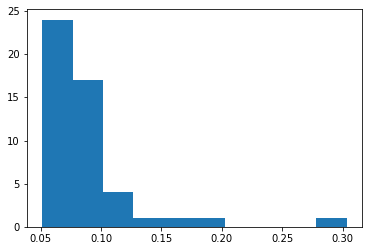

In [75]:
plt.hist(all_fraction_masked)


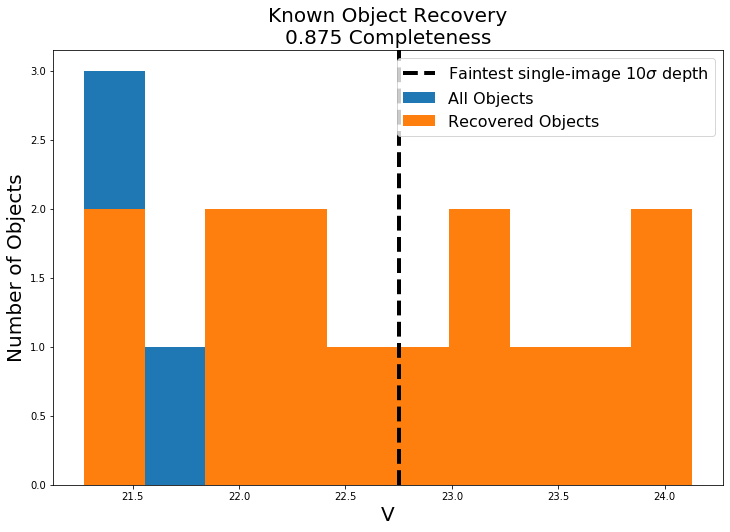

In [37]:
plt.figure(figsize=[12,8])
percent_recovered = len(found_vmag)/len(v_mag)
plt.hist(v_mag)
plt.hist(found_vmag,range=[np.min(v_mag),np.max(v_mag)])
plt.xlabel('V',fontsize=20)
plt.ylabel('Number of Objects',fontsize=20)
plt.axvline(22.75,color='black',lw=4,ls='--')
_=plt.title('Known Object Recovery\n{:.3f} Completeness'.format(percent_recovered), fontsize=20)
plt.legend([r'Faintest single-image 10$\sigma$ depth','All Objects','Recovered Objects'],fontsize=16)
#plt.savefig('object_recovery.png')

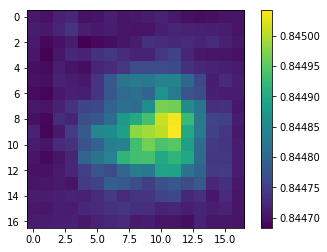

In [28]:
i = 0
j=0
size=5
heatmap = []
for j in range(22-size):
    for i in range(22-size):
        img = np.copy(stamps[0].reshape(21,21))
        img[i:i+size,j:j+size] = 0
        img /= np.sum(img)
        probs = np.concatenate(np.e**model(m_input(img)).detach().numpy())
        heatmap.append(probs[1])
plt.imshow(np.array(heatmap).reshape(22-size,22-size))
plt.colorbar()
#plt.savefig('OcclusionTesting.png')

In [16]:
foo = np.array(found_vmag)
print(len(foo[foo>22.75]))

14


(array([2., 5., 8., 6., 6., 3., 1., 2., 1., 2.]),
 array([0.30103   , 0.6767696 , 1.0525092 , 1.4282488 , 1.80398841,
        2.17972801, 2.55546761, 2.93120722, 3.30694682, 3.68268642,
        4.05842602]),
 <a list of 10 Patch objects>)

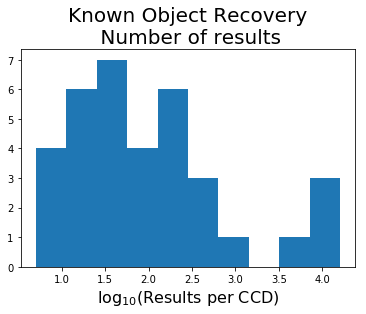

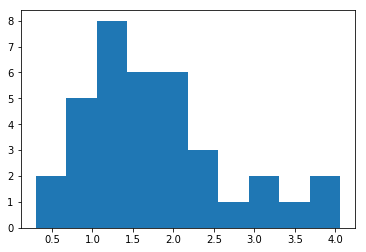

In [32]:
log_path = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/'
log_name = 'gpulh.log'
num_results = []
with open(log_path+log_name,'r') as f:
    lines = f.readlines()
    for i,line in enumerate(lines):
        if line.find('Clustering')==0:
            num_results.append(int(lines[i+1].split(' ')[1]))
plt.figure(figsize=[6,4])
plt.title('Known Object Recovery\n Number of results',fontsize=20)
plt.hist(np.log10(num_results))
plt.xlabel(r'$\log_{10}(\mathrm{Results\ per\ CCD})$', fontsize=16)

plt.figure(figsize=[6,4])
plt.hist(np.log10(num_results_neighbor))

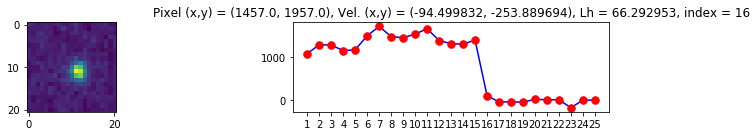

In [8]:
# Directory where output from kbmod search are located
pg_num=11
ccd_list=[29]

for ccd_num in ccd_list:
    xy_array = allObjectData[known_format.format(pg_num, ccd_num)][5]
    results_dir = '/astro/store/epyc/projects2/smotherh/DECAM_Data_Reduction/kbmod_results/{0:03}/{1:02d}/'.format(pg_num,ccd_num)
    im_dir = '/astro/store/epyc/projects2/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{0:03}/warps/{1:02d}/'.format(pg_num,ccd_num)
    suffix = 'current'

    times_filename = os.path.join(results_dir, 'times_%s.txt' % suffix)
    stamper = create_stamps()
    times_list = stamper.load_times(times_filename)

    keep_idx,results,stamper,stamps,all_stamps,lc_list,psi_list,phi_list,lc_index = loadStamps(results_dir,times_list,suffix)
    #good_idx = neighbor_filter(stamps)
    if np.count_nonzero(results) != 0:
        if len(lc_list)==1:
            results=[results]
        #stamps_fig = stamper.target_stamps(results, lc_list, lc_index, stamps, 0.03, target_xy=[1458.1289606563355,1957.3085753658502],rtol=0.001)
        stamps_fig, object_found, found_idx = stamper.target_stamps(results, lc_list, lc_index, stamps, 0.03, target_xy=xy_array,atol=3,vel_tol=15)
        #stamps_fig, _, found_idx = stamper.target_stamps(results[good_idx], np.array(lc_list)[good_idx], np.array(lc_index)[good_idx], stamps[good_idx], 0.03, target_xy=xy_array,atol=3,vel_tol=15)
        #stamps_fig = stamper.plot_stamps(results, lc_list, lc_index, stamps, 0.03)

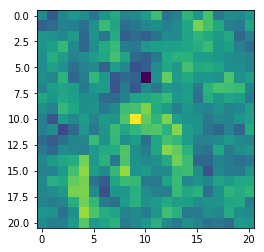

In [21]:
false_list = [element for i, element in enumerate(stamps) if i not in found_idx]
plt.imshow(false_list[19].reshape(21,21))

There are 29 results.


Text(0.5, 1.0, 'Likelihood')

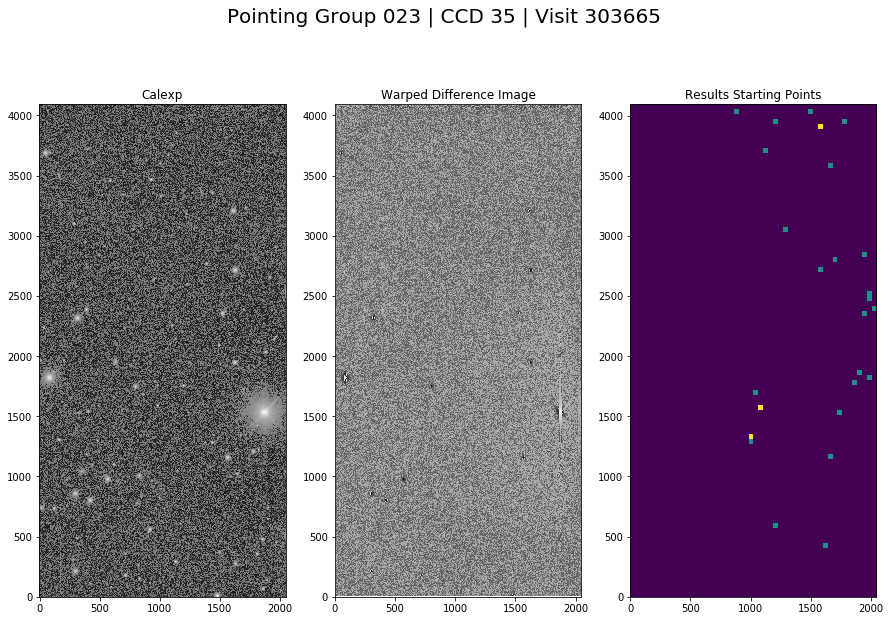

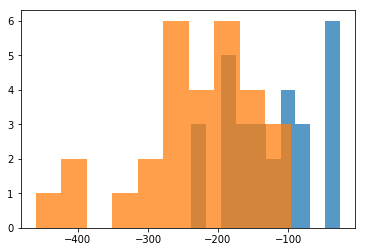

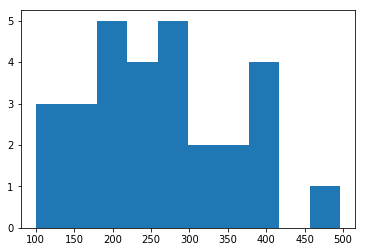

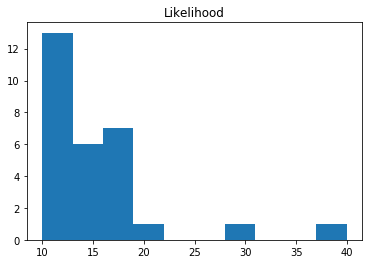

In [137]:
from astropy.io import fits
from matplotlib.patches import Circle
import numpy as np

def normalFilter(data):
    return(data)

def plotResults(pg_num, ccd_num, visit_id, results, filter_type='arcsinh', zoom=False, zoom_mask=[250,750,250,500]):
    if filter_type==None:
        apply_filter=normalFilter
    elif filter_type=='arcsinh':
        apply_filter=np.arcsinh
    elif filter_type=='log':
        apply_filter=np.log
        
    fig,[ax1,ax2,ax3]=plt.subplots(nrows=1,ncols=3,figsize=[15,10])
    warps_path = '/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{pg:03d}/warps/{ccd:02d}/{visit:06d}.fits'
    calexp_path = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{pg:03d}/processed_data/rerun/rerun_processed_data/{visit:07d}/calexp/calexp-{visit:07d}_{ccd:02d}.fits'
    with fits.open(calexp_path.format(pg=pg_num, ccd=ccd_num, visit=visit_id)) as hdul:
        data = hdul[1].data
        if zoom:
            data = data[zoom_mask[0]:zoom_mask[1],zoom_mask[2]:zoom_mask[3]]
        im = ax1.imshow(apply_filter(data),origin='lower',cmap='gray')
        ax1.set_title('Calexp')
        #fig.colorbar(im, ax=ax1)

    with fits.open(warps_path.format(pg=pg_num, ccd=ccd_num, visit=visit_id)) as hdul:
        data = hdul[1].data
        if zoom:
            data = data[zoom_mask[0]:zoom_mask[1],zoom_mask[2]:zoom_mask[3]]
        ax2.set_title('Warped Difference Image')
        im = ax2.imshow(apply_filter(data),origin='lower',cmap='gray')
        #fig.colorbar(im, ax=ax2)
    fig.suptitle('Pointing Group {:03d} | CCD {:02d} | Visit {:06d}'.format(pg_num,ccd_num,visit_id),fontsize=20)

    x = [res[2] for res in results]
    y = [res[3] for res in results]
    num_obs = [res[6] for res in results]
    data_lims = np.shape(data)
    H, xedges, yedges = np.histogram2d(x, y, range=[[0,data_lims[1]],[0,data_lims[0]]], bins=(100,50))
    _ = ax3.imshow(H, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower')
    _ = ax3.set_title('Results Starting Points')
    return(fig)
#'lh', 'flux', 'x', 'y', 'vx', 'vy', 'num_obs'
lh = [res[0] for res in results]
flux = [res[1] for res in results]
vx = np.array([res[4] for res in results])
vy = np.array([res[5] for res in results])
print('There are {} results.'.format(len(results)))
fig = plotResults(23, 35, 303665, results)
plt.figure()
plt.hist(vx,alpha=0.75)
plt.hist(vy,alpha=0.75)
plt.figure()
speed = np.sqrt(vx**2+vy**2)
plt.hist(speed)
plt.figure()
plt.hist(lh)
plt.title('Likelihood')

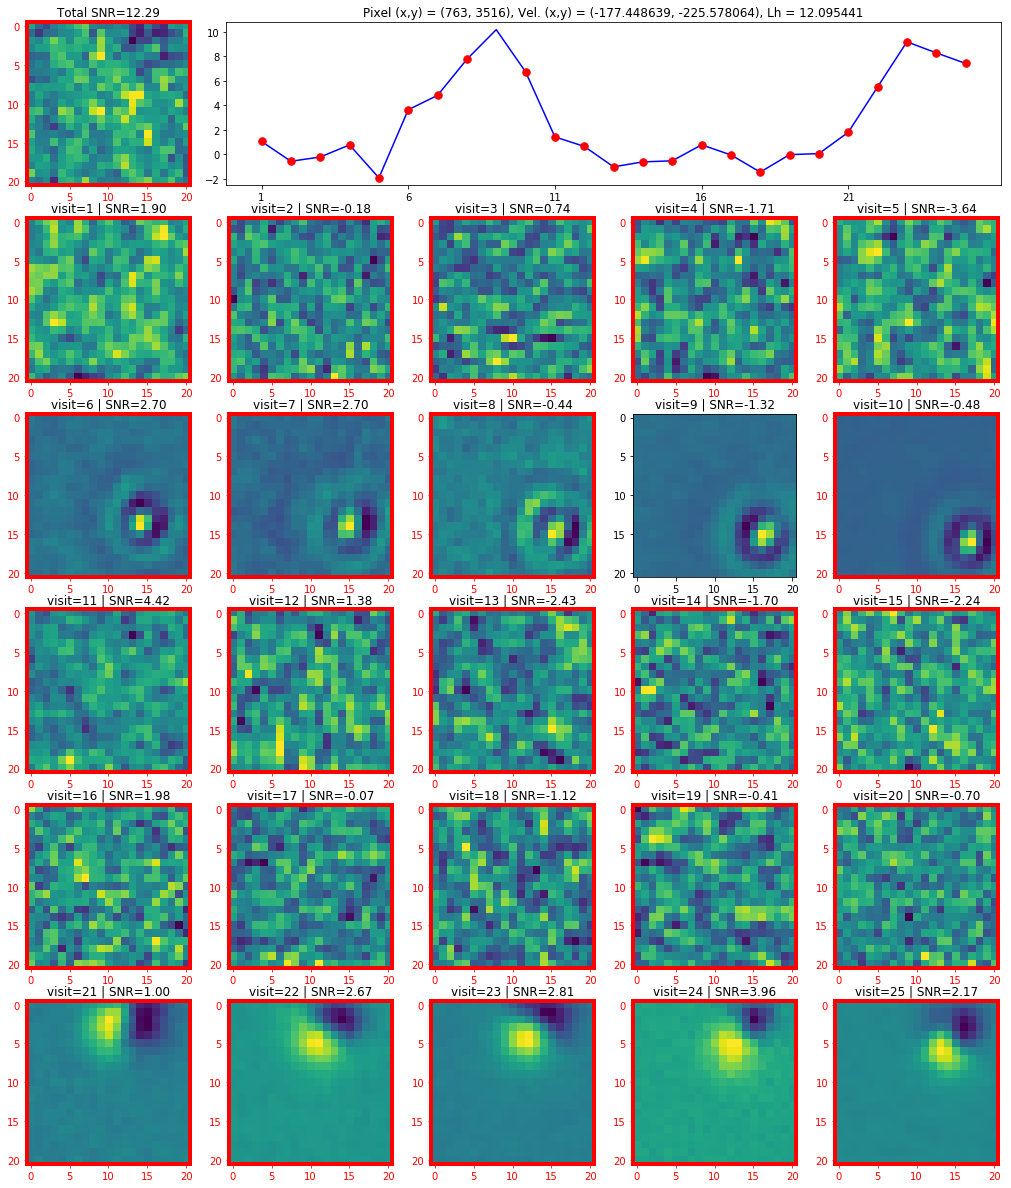

In [135]:
possible=[26]
stamper = create_stamps()
for i in possible:
    psi = psi_list[i]
    phi = phi_list[i]
    masked_phi = np.copy(phi)
    masked_phi[phi==0] = 1e9
    lh = psi/np.sqrt(masked_phi)
    fig = stamper.plot_all_stamps(results[i],lh,lc_index[i],stamps[i],all_stamps[i],sample=False)
    #fig = stamper.plot_all_stamps(results[i],lc_list[i],lc_index[i],stamps[i],all_stamps[i],sample=False)
#plt.savefig('DEEPNewObjectSample.png'.format(i))

In [86]:
from skimage import measure
def returnMoms(mom):
    return(np.array([mom[2, 0], mom[0, 2], mom[1, 1], mom[1, 0], mom[0, 1], mom[3,0], mom[0,3]]))
    
def normStamp(stamp):
    stamp = stamp.reshape(21,21)
    s = stamp - np.min(stamp)
    s /= np.sum(s)
    s = np.array(s, dtype=np.dtype('float64')).reshape(21, 21)
    return(s)

all_moms = []
all_coadd_stamps = np.load('stamp_training_set.npy')
for stamp in all_coadd_stamps:
    cppStamp = normStamp(stamp)
    cppMoms = measure.moments_central(cppStamp, center=[10,10])
    all_moms.append(returnMoms(cppMoms))
all_moms = np.array(all_moms)

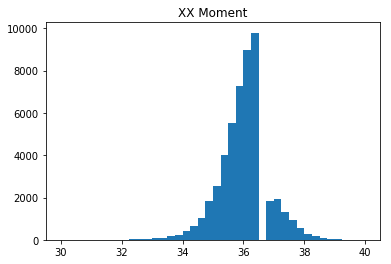

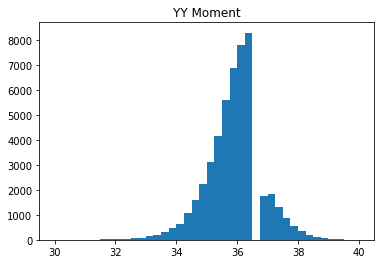

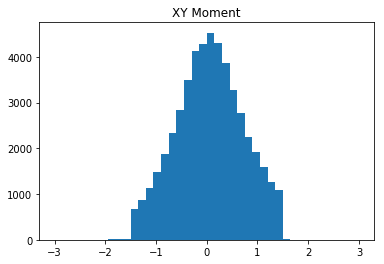

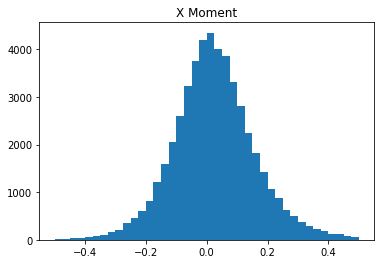

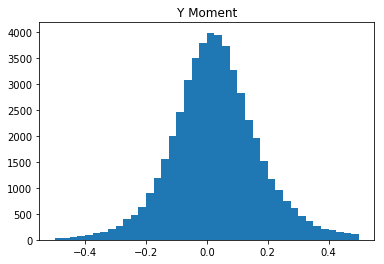

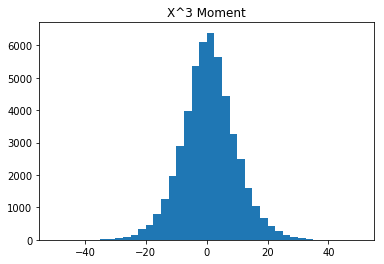

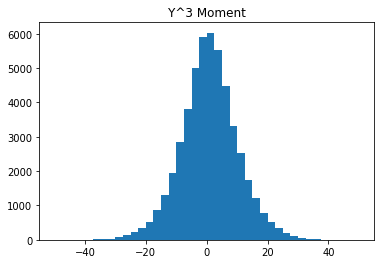

In [89]:
def plotMomHist(moms, title='', range=None, bins=None):
    plt.figure()
    plt.hist(moms,range=range,bins=bins)
    plt.title(title)

plotMomHist(all_moms[:,0], title='XX Moment', range=[30,40], bins=40)
plotMomHist(all_moms[:,1], title='YY Moment', range=[30,40], bins=40)
plotMomHist(all_moms[:,2], title='XY Moment', range=[-3,3], bins=40)
plotMomHist(all_moms[:,3], title='X Moment', range=[-0.5,0.5], bins=40)
plotMomHist(all_moms[:,4], title='Y Moment', range=[-0.5,0.5], bins=40)
plotMomHist(all_moms[:,5], title='X^3 Moment', range=[-50,50], bins=40)
plotMomHist(all_moms[:,6], title='Y^3 Moment', range=[-50,50], bins=40)


In [80]:
(1.12<36) & (12.3<36) & ( 40<1.5)

False

In [ ]:

# Directory where output from kbmod search are located
ccd_list=[43]
for ccd_num in ccd_list:
    results_dir = '/astro/store/pogo4/smotherh/DEEP/PointingGroups/A0b/results/{}/'.format(ccd_num)
    im_dir = '/astro/store/pogo4/smotherh/DEEP/PointingGroups/A0b/warps/{}/'.format(ccd_num)
    #results_dir = '/nvme/users/smotherh/DEEP/PointingGroups/A0b/results/{}/'.format(ccd_num)
    #im_dir = '/nvme/users/smotherh/DEEP/PointingGroups/A0b/warps/{}/'.format(ccd_num)
    suffix = 'sG_3'

    times_filename = os.path.join(results_dir, 'times_%s.txt' % suffix)
    stamper = create_stamps()
    times_list = stamper.load_times(times_filename)

    keep_idx,results,stamper,stamps,all_stamps,lc_list,lc_index = makeStamps(results_dir,times_list,suffix)

    if np.count_nonzero(results) != 0:
        if len(lc_list)==1:
            results=[results]
        #stamps_fig = stamper.target_stamps(results, lc_list, lc_index, stamps, 0.01, target_xy=[1217.9613127459104,325.56229130147136],rtol=0.06)
        stamps_fig = stamper.plot_stamps(results, lc_list, lc_index, stamps, 0.0)

In [19]:
l_num = 32
tl = np.array(np.sort(times_list[l_num]) - np.min(times_list[l_num]))
print(results[l_num]['vx']*tl + results[l_num]['x'], results[l_num]['vy']*tl + results[l_num]['y'])

[1692.         1692.22275539 1692.75831903 1759.98532658] [285.         285.41229966 286.40357849 410.83456107]


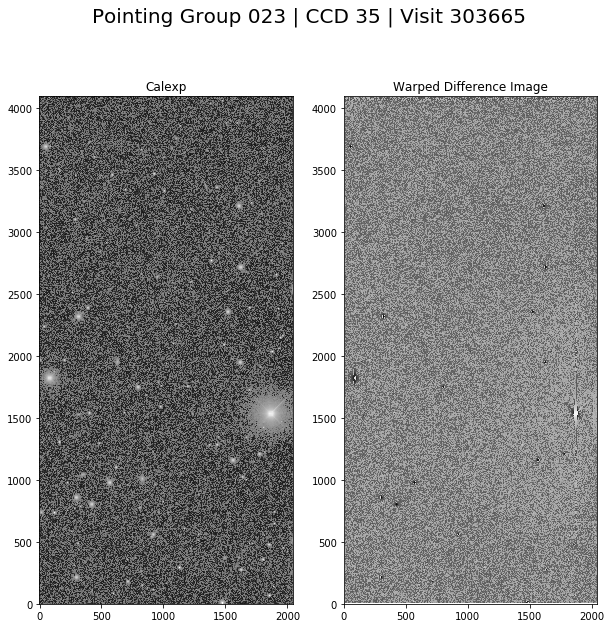

In [396]:
from astropy.io import fits
from matplotlib.patches import Circle

def normalFilter(data):
    return(data)

def plotImages(pg_num, ccd_num, visit_id, filter_type='arcsinh', zoom=False, zoom_mask=[250,750,250,500]):
    if filter_type==None:
        apply_filter=normalFilter
    elif filter_type=='arcsinh':
        apply_filter=np.arcsinh
    elif filter_type=='log':
        apply_filter=np.log
        
    fig,[ax1,ax2]=plt.subplots(nrows=1,ncols=2,figsize=[10,10])
    warps_path = '/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{pg:03d}/warps/{ccd:02d}/{visit:06d}.fits'
    calexp_path = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{pg:03d}/processed_data/rerun/rerun_processed_data/{visit:07d}/calexp/calexp-{visit:07d}_{ccd:02d}.fits'
    with fits.open(calexp_path.format(pg=pg_num, ccd=ccd_num, visit=visit_id)) as hdul:
        data = hdul[1].data
        if zoom:
            data = data[zoom_mask[0]:zoom_mask[1],zoom_mask[2]:zoom_mask[3]]
        im = ax1.imshow(apply_filter(data),origin='lower',cmap='gray')
        ax1.set_title('Calexp')
        #fig.colorbar(im, ax=ax1)

    with fits.open(warps_path.format(pg=pg_num, ccd=ccd_num, visit=visit_id)) as hdul:
        data = hdul[1].data
        if zoom:
            data = data[zoom_mask[0]:zoom_mask[1],zoom_mask[2]:zoom_mask[3]]
        ax2.set_title('Warped Difference Image')
        im = ax2.imshow(apply_filter(data),origin='lower',cmap='gray')
        #fig.colorbar(im, ax=ax2)
    fig.suptitle('Pointing Group {:03d} | CCD {:02d} | Visit {:06d}'.format(pg_num,ccd_num,visit_id),fontsize=20)
    return(fig)
fig = plotImages(23, 35, 303665, zoom=False, zoom_mask=[1100,1600,0,250])
plt.savefig('ImDiff_Example')

In [40]:
import bokeh.plotting as bkp
pg_num=29
ccd_num=54
visit_id=435146
calexp_path = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{pg:03d}/processed_data/rerun/rerun_processed_data/{visit:07d}/calexp/calexp-{visit:07d}_{ccd:02d}.fits'
with fits.open(calexp_path.format(pg=pg_num, ccd=ccd_num, visit=visit_id)) as hdul:
    data = np.array(hdul[1].data)
    print(np.shape(data[0]))
    fig = bkp.figure()
    fig.image([np.arcsinh(data)],0,0,1000,2000)

    bkp.show(fig)  # open a browser

(2046,)


In [304]:
numImages = 30
psi = 500*(np.random.random(numImages)-.1)
phi = 500*(np.random.random(numImages))
psi = np.append(psi,np.zeros(70))
phi = np.append(phi,np.zeros(70))
foophi = np.copy(phi)
foophi[foophi==0]=1
data = psi/np.sqrt(foophi)
idxArray = np.linspace(0,numImages-1,numImages)
idxArray = np.append(idxArray,-np.ones(70)).astype(int)
print(data)
for j in range(numImages):
    for k in range(j+1,numImages):
        if data[idxArray[j]]>data[idxArray[k]]:
            tmp = idxArray[j]
            idxArray[j] = idxArray[k]
            idxArray[k] = tmp
print(idxArray)
print(data[idxArray[0:numImages]])
np.all(np.diff(data[idxArray[0:numImages]])>0)

[ 2.93471208 -2.13035749  5.76550908  9.05131105 57.3025685  58.02967513
 -1.05574743 19.06582408 13.93544239 17.37816197 12.63468288 21.34998815
 14.84165408 13.33641222 10.45106693  4.46336451 12.97500323 34.44423899
  0.98789722  4.02978758  7.10643021 26.71809649  0.096816   11.69511721
 14.18388432  2.86608114 30.59662283  3.379311   -0.52897794 21.83497531
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          

True

In [54]:
import torch
from classify import Net
model = torch.load('./kbmod_cnn_background.pt')
model.cpu()
model.float()
model.eval()AdaptiveLogSoftmaxWithLoss

def m_input(arr):
    dat = torch.tensor([[arr]])
    dat = dat.to('cpu', torch.float)
    return dat
def predict(img):
    val = model(m_input(img)).argmax(dim=1, keepdim=True)
    return val.item()
def mispredictions(imgs, correct_answer):
    wrong = []
    for idx, img in enumerate(imgs):
        if (not predict(img) == correct_answer):
            wrong.append(idx)
    return wrong



In [55]:
true_false_list = []
for stamp in stamps:
    stamp = stamp.reshape(21,21)
    true_false_list.append(predict(stamp))

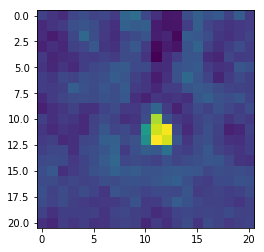

In [14]:
plt.imshow(stamps[0].reshape(21,21))

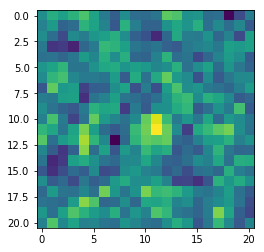

In [39]:
true_stamp = stamps[np.where(np.array(true_false_list)==1)]
plt.imshow(true_stamp.reshape(21,21))

tensor([[-4.2513e-04, -7.7632e+00]], grad_fn=<LogSoftmaxBackward>)


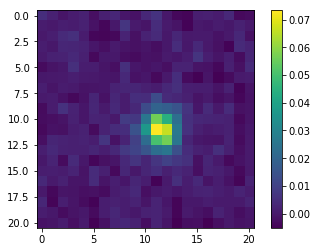

In [94]:
print(model(m_input(found_stamps[0].reshape(21,21))))
plt.imshow(found_stamps[0].reshape(21,21))
plt.colorbar()

In [79]:
filt_results[]

array([[1.49837600e+06, 2.92091200e+06, 1.94000000e+02, 4.49803494e+03],
       [2.93640100e+06, 5.60893100e+06, 2.20000000e+02, 4.94305072e+03],
       [5.68111600e+06, 1.06379600e+07, 2.43000000e+02, 5.64418184e+03],
       [1.08234700e+07, 1.99047720e+07, 2.70000000e+02, 8.11884583e+03]])

In [17]:
import pandas as pd
results_per_pixel = [1,2,4,8]
num_results_df = pd.DataFrame(columns=['res_per_pixel','f_keep_res','f_all_res','f_pass_results','f_time','nf_keep_res','nf_all_res','nf_pass_results','nf_time'])
num_results_df['res_per_pixel'] = results_per_pixel
filt_results = []
no_filt_results = []
for i, num_res in enumerate(results_per_pixel):
    log_nums = parse_num_results('/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/n{}_2335.log'.format(num_res))
    filt_results.append(log_nums)
    log_nums = parse_num_results('/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/nofilt_n{}_2335.log'.format(num_res))
    no_filt_results.append(log_nums)
filt_results = np.array(filt_results)
no_filt_results = np.array(no_filt_results)
num_results_df['f_keep_res'] = filt_results[:,0]
num_results_df['f_all_res'] = filt_results[:,1]
num_results_df['f_pass_res'] = filt_results[:,2]
num_results_df['f_time'] = filt_results[:,3]
num_results_df['nf_keep_res'] = no_filt_results[:,0]
num_results_df['nf_all_res'] = no_filt_results[:,1]
num_results_df['nf_pass_res'] = no_filt_results[:,2]
num_results_df['nf_time'] = no_filt_results[:,3]

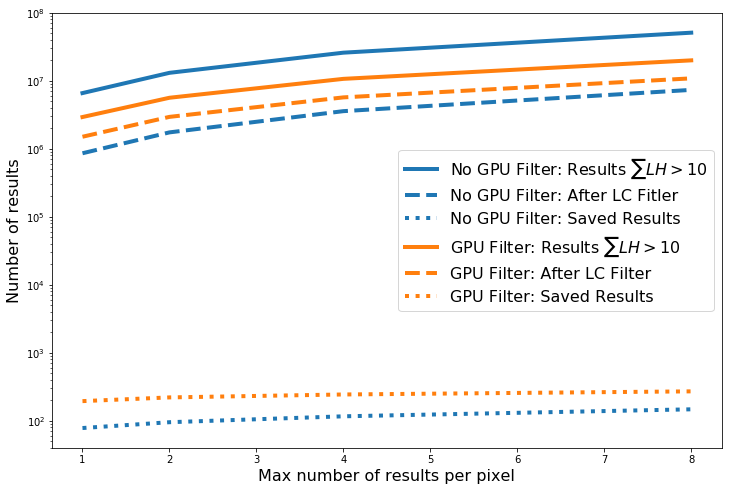

In [18]:
plt.figure(figsize=[12,8])
plt.semilogy(results_per_pixel,num_results_df['nf_all_res'],c='tab:blue',lw=4)
plt.semilogy(results_per_pixel,num_results_df['nf_keep_res'],c='tab:blue',ls='--',lw=4)
plt.semilogy(results_per_pixel,num_results_df['nf_pass_res'],c='tab:blue',ls=':',lw=4)
plt.semilogy(results_per_pixel,num_results_df['f_all_res'],c='tab:orange',lw=4)
plt.semilogy(results_per_pixel,num_results_df['f_keep_res'],c='tab:orange',ls='--',lw=4)
plt.semilogy(results_per_pixel,num_results_df['f_pass_res'],c='tab:orange',ls=':',lw=4)


plt.legend([r'No GPU Filter: Results $\sum{LH} > 10$','No GPU Filter: After LC Fitler','No GPU Filter: Saved Results',
            r'GPU Filter: Results $\sum{LH} > 10$', 'GPU Filter: After LC Filter', 'GPU Filter: Saved Results'],fontsize=16)
plt.xlabel('Max number of results per pixel', fontsize=16)
plt.ylabel('Number of results', fontsize=16)
plt.savefig('Num_Results_Filt_Nofilt.png')

In [19]:
np.mean(num_results_df['f_all_res']/num_results_df['nf_all_res'])

0.41958495495787973

In [16]:
def parse_num_results(filename):
    log_nums = np.array([])
    with open(filename) as f:
        get_next_line = False
        for line in f:
            if 'total results' in line:
                for t in line.split():
                    try:
                        log_nums = np.append(log_nums,float(t))
                    except ValueError:
                        pass
            if get_next_line:
                for t in line.split():
                    try:
                        log_nums = np.append(log_nums,float(t))
                    except ValueError:
                        pass
            if 'Clustering' in line:
                # Get all the floats in the log after Clustering
                # This will add total number of saved results and processing time taken
                get_next_line=True
    return(log_nums)

In [15]:
print('''#!/bin/bash
#SBATCH -N 2
#SBATCH -p GPU
#SBATCH --ntasks-per-node 28
#SBATCH -t 5:00:00
#SBATCH --gres=gpu:p100:2

# echo commands to stdout
set -x

# move to working directory
# this job assumes:
# - all input data is stored in this directory
# - all output should be stored in this directory
cd /pylon5/groupname/username/path-to-directory''')

#!/bin/bash
        #SBATCH -N 2
#SBATCH -p GPU
#SBATCH --ntasks-per-node 28
#SBATCH -t 5:00:00
#SBATCH --gres=gpu:p100:2

# echo commands to stdout
set -x

# move to working directory
# this job assumes:
# - all input data is stored in this directory
# - all output should be stored in this directory
cd /pylon5/groupname/username/path-to-directory


In [33]:
import numpy as np
good_pointing_groups = [16, 17, 18, 19, 20, 21, 22, 23, 32, 79, 95,
                        179, 190, 191, 192, 193, 194, 195, 196, 197,
                        202, 203, 204, 205, 284, 285, 288, 289, 290,
                        291, 296, 297, 298, 300, 301, 302, 305, 306,
                        307, 308, 309, 310, 311, 313, 314, 316, 317,
                        318, 320, 323, 324, 325]

def writeXSEDESlurm(pg_num):
    gpu_num = 0
    ccd_num = np.linspace(1,62,62).astype(int)
    ccd_num = ccd_num[(ccd_num!=2) & (ccd_num!=61) & (ccd_num!=31)]
    for i, ccd in enumerate(ccd_num):
        if gpu_num == 0:
            if i<len(ccd_num)-1:
                file_name = "pg{}_{:02}-{:02}.slurm".format(pg_num,ccd_num[i],ccd_num[i+1])
            else:
                file_name = "pg{}_{:02}.slurm".format(pg_num,ccd_num[i])
            with open(file_name, "w") as f:
                f.write('''#!/bin/bash
#SBATCH -N 1
#SBATCH -p GPU
#SBATCH --ntasks-per-node 28
#SBATCH -t 2:00:00
#SBATCH --gres=gpu:p100:2


# move to working directory
# this job assumes:
# - all input data is stored in this directory
# - all output should be stored in this directory
source ~/.bashrc
source activate python36
cd ~/pylon_home/kbmod
source setup.bash
cd ..\n''')
                f.write('{{ CUDA_VISIBLE_DEVICES={2} time python ~/pylon_home/lori_allen_search.py {0} {1} ; }} > ~/pylon_home/logs/{0}_{1:02}.log 2>&1 &\n'.format(pg_num,ccd_num[i],0))
                if i<len(ccd_num)-1:
                    f.write('{{ CUDA_VISIBLE_DEVICES={2} time python ~/pylon_home/lori_allen_search.py {0} {1} ; }} > ~/pylon_home/logs/{0}_{1:02}.log 2>&1 &\n'.format(pg_num,ccd_num[i+1],1))
                f.write('wait')
            gpu_num = 1
        else:
            gpu_num = 0
for pg in good_pointing_groups:
    writeXSEDESlurm(pg)

1109
292
1134
1110
317
293


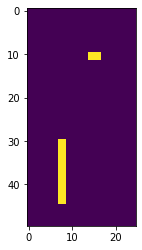

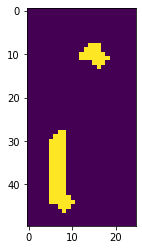

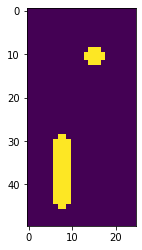

In [498]:
width = 25
height = 50
mask = np.zeros([height,width])
mask[10:12,14:17] = 1
mask[30:45,7:9] = 1
_=plt.imshow(mask)

def grow_mask(mask):
    height, wdith = np.shape(mask)
    mask = np.concatenate(mask)
    for i in range(width):
        for j in range(height):
            center = width*j+i
            if (i+1<width) and (mask[center+1]==1):
                mask[center]=-9999
                continue
            if (i-1>=0) and (mask[center-1]==1):
                mask[center]=-9999
                print(center)
                continue
            if (j+1<height) and (mask[center+width]==1):
                mask[center]=-9999
                continue
            if (j-1>=0) and (mask[center-width]==1):
                mask[center]=-9999
                continue
    mask[mask==-9999]=1
    return(mask.reshape(height, width))


def grow_mask_fixed(mask):
    height, wdith = np.shape(mask)
    mask = np.concatenate(mask)
    return_mask = np.copy(mask)
    for i in range(width):
        for j in range(height):
            center = width*j+i
            if (i+1<width) and (mask[center+1]==1):
                return_mask[center]=-9999
                continue
            if (i-1>=0) and (mask[center-1]==1):
                return_mask[center]=-9999
                continue
            if (j+1<height) and (mask[center+width]==1):
                return_mask[center]=-9999
                continue
            if (j-1>=0) and (mask[center-width]==1):
                return_mask[center]=-9999
                continue
    mask[return_mask==-9999]=1
    return(mask.reshape(height, width))
plt.figure()
_=plt.imshow(grow_mask(mask))
plt.figure()
_=plt.imshow(grow_mask_fixed(mask))


76


Text(0.5, 0, 'Number of Results')

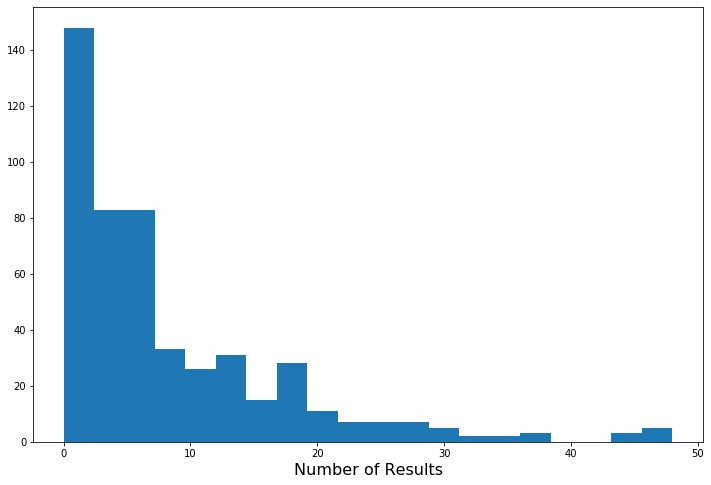

In [73]:
import matplotlib.pyplot as plt
num_results = np.loadtxt('/epyc/users/smotherh/results_16-79.txt')
plt.figure(figsize=[12,8])
plt.hist(num_results[num_results<50],bins=20)
print(len(num_results[num_results>=50]))
plt.xlabel('Number of Results',fontsize=16)